___
#### Instalação dos módulos necessários

In [ ]:
%pip install duckdb
%pip install imbalanced-learn
%pip install keras
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install pydot
%pip install scikit-learn
%pip install seaborn
%pip install warnings

#### Importação dos módulos necessários

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import duckdb as ddb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
from Custom import Custom_LSTM as CL

#### Ignora warnings que serão gerados

In [2]:
warnings.filterwarnings("ignore")

___

#### Leitura e análise do conjunto de treino das ações do Banco do Brasil (BBAS3)

In [3]:
raw_bbas3_train = pd.read_csv("_datasets/bbas3/treino.csv")
raw_bbas3_train.tail(5)

,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
4730,4731,2019-03-19,39.001053,38.947137,1,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267,38.555489,37.248150,37.395866,37.898129,37.373718,38.333908,38.777073,38.570271,39.212849
4731,4732,2019-03-20,38.126942,38.865118,-1,39.001053,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267,38.555489,37.248150,37.395866,37.898129,37.373718,38.333908,38.777073,38.570271
4732,4733,2019-03-21,37.326935,38.711299,-1,38.126942,39.001053,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267,38.555489,37.248150,37.395866,37.898129,37.373718,38.333908,38.777073
4733,4734,2019-03-22,35.297241,38.369894,-1,37.326935,38.126942,39.001053,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267,38.555489,37.248150,37.395866,37.898129,37.373718,38.333908
4734,4735,2019-03-25,35.549099,38.087814,-1,35.297241,37.326935,38.126942,39.001053,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267,38.555489,37.248150,37.395866,37.898129,37.373718


Perceba que, ao importar o conjunto de dados de treino, podemos realizar algumas alterações para facilitar a análise e manipulação das informações.

- Remoção de variáveis

    - "Unnamed: 0" : o registro representa um índice.
    - "Date" : o registro representa a data de coleta do dado.
    - "Smoothed_Close" : o registro representa o valor suavizado do fechamento do ativo - citado como "apenas uma curiosidade".

- Ordenação das variáveis

    - Para facilitar a interpretação, iremos ordenar o conjunto de dados de treino pelas variáveis independentes seguidas da variável dependente.

In [4]:
spec_bbas3_train = raw_bbas3_train.drop(columns="Smoothed_Close")
spec_bbas3_train = spec_bbas3_train[["Close", "Past_1_Days_Close", "Past_2_Days_Close", "Past_3_Days_Close", "Past_4_Days_Close", "Past_5_Days_Close", "Past_6_Days_Close", "Past_7_Days_Close", "Past_8_Days_Close", "Past_9_Days_Close", "Past_10_Days_Close", "Past_11_Days_Close", "Past_12_Days_Close", "Past_13_Days_Close", "Past_14_Days_Close", "Past_15_Days_Close", "Label"]]
spec_bbas3_train.tail(5)

,Close,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close,Label
4730,39.001053,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267,38.555489,37.248150,37.395866,37.898129,37.373718,38.333908,38.777073,38.570271,39.212849,1
4731,38.126942,39.001053,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267,38.555489,37.248150,37.395866,37.898129,37.373718,38.333908,38.777073,38.570271,-1
4732,37.326935,38.126942,39.001053,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267,38.555489,37.248150,37.395866,37.898129,37.373718,38.333908,38.777073,-1
4733,35.297241,37.326935,38.126942,39.001053,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267,38.555489,37.248150,37.395866,37.898129,37.373718,38.333908,-1
4734,35.549099,35.297241,37.326935,38.126942,39.001053,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267,38.555489,37.248150,37.395866,37.898129,37.373718,-1


Com o conjunto de dados de treino ordenado e livre de variáveis que não serão utilizadas, podemos realizar a análise inicial dos dados.

In [5]:
spec_bbas3_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4735 entries, 0 to 4734
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Close               4735 non-null   float64
 1   Past_1_Days_Close   4735 non-null   float64
 2   Past_2_Days_Close   4735 non-null   float64
 3   Past_3_Days_Close   4735 non-null   float64
 4   Past_4_Days_Close   4735 non-null   float64
 5   Past_5_Days_Close   4735 non-null   float64
 6   Past_6_Days_Close   4735 non-null   float64
 7   Past_7_Days_Close   4735 non-null   float64
 8   Past_8_Days_Close   4735 non-null   float64
 9   Past_9_Days_Close   4735 non-null   float64
 10  Past_10_Days_Close  4735 non-null   float64
 11  Past_11_Days_Close  4735 non-null   float64
 12  Past_12_Days_Close  4735 non-null   float64
 13  Past_13_Days_Close  4735 non-null   float64
 14  Past_14_Days_Close  4735 non-null   float64
 15  Past_15_Days_Close  4735 non-null   float64
 16  Label 

Conforme apresentado acima, notamos que nenhuma das variáveis apresenta valores nulos, portanto, neste momento, não precisaremos remover ou realizar a inputação de valores como tratamento a valores ausentes.  

Dessa forma, como próximos passos, iremos analisar o comportamento das variáveis a fim de entender se o conjunto de dados de treino está balanceado (número de compras e vendas similar) e, em seguida, verificar a correlação entre as variáveis.

In [6]:
label_distribution = ddb.sql("""SELECT Label, COUNT(*) AS Regs from spec_bbas3_train GROUP BY 1""").to_df()
size = spec_bbas3_train.shape[0]
buy_count = label_distribution["Regs"][0]
sell_count = label_distribution["Regs"][1]
buy_percentual = round((buy_count / size) * 100, 2)
sell_percentual = round((sell_count / size) * 100, 2)

print(f"O conjunto de dados possui {size} registros, onde:")
print(f" -> Vendas: {buy_count} ou {buy_percentual}%")
print(f" -> Compras: {sell_count} ou {sell_percentual}%")

O conjunto de dados possui 4735 registros, onde:
 -> Vendas: 2602 ou 54.95%
 -> Compras: 2133 ou 45.05%


O conjunto de dados de treino apresenta uma boa distribuição entre as classes, sendo assim, não será necessário aplicar nenhuma técnica de amostragem para balancear os dados, o que geralmente é feito para evitar que o modelo tornesse especialista em uma única classe.

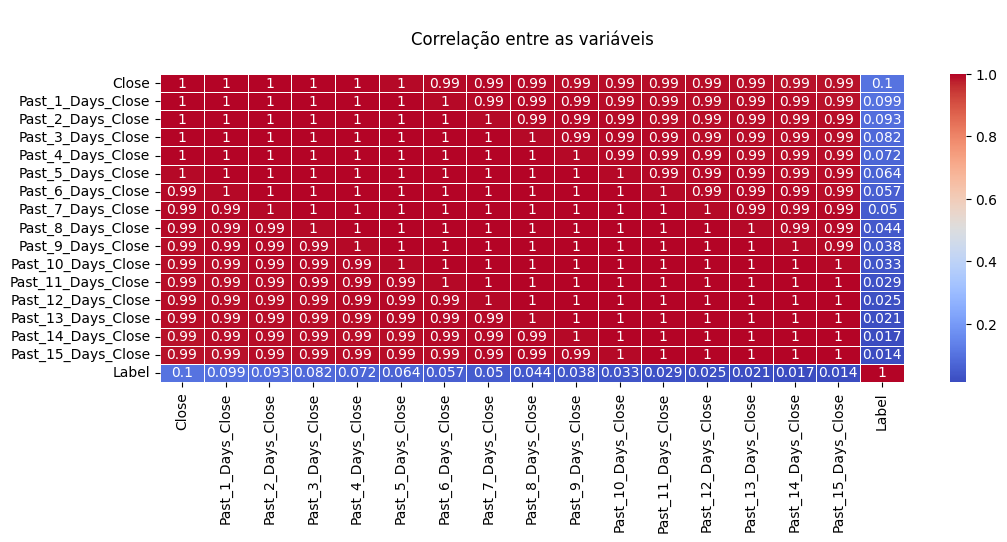

In [7]:
correlation = spec_bbas3_train.select_dtypes("number").corr()

plt.figure(figsize=(12, 4))

sns.heatmap(
    correlation, 
    annot=True, 
    annot_kws={"size" : 10},
    cmap="coolwarm",
    cbar=True,
    linewidths=0.5,
    linecolor="white"
)

plt.title("\nCorrelação entre as variáveis\n", fontdict={"size" : 12})

plt.show()

Além disso, há outros dois comportamentos importantes a serem notados:

- Variável dependente: a correlação entre a ação de venda/compra diminui ao passar dos dias, ou seja, considerando APENAS o que é apresentado acima, poderíamos pressupor que a ação é tomada com base nos dados mais recentes, ou seja, uma janela mais curta de dias.

- Variáveis independentes: diferente da variável dependente, todas as variáveis independentes apresentam uma alta correlação entre sí, o que nos leva a pensar que o valor de fechamento em D-15 influencia em D-14 e assim sucessivamente.

Posto isso, iremos desenvolver um modelo baseline para fazer uma classificação inicial das ações.

#### Leitura e análise do conjunto de teste das ações do Banco do Brasil (BBAS3)

In [8]:
raw_bbas3_test = pd.read_csv("_datasets/bbas3/teste.csv")
raw_bbas3_test.tail(5)

,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
1180,5916,2023-12-21,54.290001,53.331493,1,54.209999,54.849998,54.650002,54.610001,53.330002,52.980000,52.500000,54.097694,54.107632,53.531277,52.676685,53.829391,53.829391,54.038074,53.928764
1181,5917,2023-12-22,54.439999,53.442343,1,54.290001,54.209999,54.849998,54.650002,54.610001,53.330002,52.980000,52.500000,54.097694,54.107632,53.531277,52.676685,53.829391,53.829391,54.038074
1182,5918,2023-12-26,54.939999,53.592109,1,54.439999,54.290001,54.209999,54.849998,54.650002,54.610001,53.330002,52.980000,52.500000,54.097694,54.107632,53.531277,52.676685,53.829391,53.829391
1183,5919,2023-12-27,54.860001,53.718898,1,54.939999,54.439999,54.290001,54.209999,54.849998,54.650002,54.610001,53.330002,52.980000,52.500000,54.097694,54.107632,53.531277,52.676685,53.829391
1184,5920,2023-12-28,55.389999,53.886008,1,54.860001,54.939999,54.439999,54.290001,54.209999,54.849998,54.650002,54.610001,53.330002,52.980000,52.500000,54.097694,54.107632,53.531277,52.676685


Para mantermos o padrão, iremos realizar os mesmos tratamentos que foram realizados no conjunto de treino no conjunto de teste, ou seja, a remoção das colunas "Unamed: 0", "Date" e "Smoothed_Close" (que não serão utilizadas no treinamento dos modelos) e a ordenação das variáveis para facilitar a leitura.

In [9]:
spec_bbas3_test = raw_bbas3_test.drop(columns="Smoothed_Close")
spec_bbas3_test = spec_bbas3_test[["Close", "Past_1_Days_Close", "Past_2_Days_Close", "Past_3_Days_Close", "Past_4_Days_Close", "Past_5_Days_Close", "Past_6_Days_Close", "Past_7_Days_Close", "Past_8_Days_Close", "Past_9_Days_Close", "Past_10_Days_Close", "Past_11_Days_Close", "Past_12_Days_Close", "Past_13_Days_Close", "Past_14_Days_Close", "Past_15_Days_Close", "Label"]]
spec_bbas3_test.tail(5)

,Close,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close,Label
1180,54.290001,54.209999,54.849998,54.650002,54.610001,53.330002,52.980000,52.500000,54.097694,54.107632,53.531277,52.676685,53.829391,53.829391,54.038074,53.928764,1
1181,54.439999,54.290001,54.209999,54.849998,54.650002,54.610001,53.330002,52.980000,52.500000,54.097694,54.107632,53.531277,52.676685,53.829391,53.829391,54.038074,1
1182,54.939999,54.439999,54.290001,54.209999,54.849998,54.650002,54.610001,53.330002,52.980000,52.500000,54.097694,54.107632,53.531277,52.676685,53.829391,53.829391,1
1183,54.860001,54.939999,54.439999,54.290001,54.209999,54.849998,54.650002,54.610001,53.330002,52.980000,52.500000,54.097694,54.107632,53.531277,52.676685,53.829391,1
1184,55.389999,54.860001,54.939999,54.439999,54.290001,54.209999,54.849998,54.650002,54.610001,53.330002,52.980000,52.500000,54.097694,54.107632,53.531277,52.676685,1


Com o tratamento realizado, analisaremos se de fato não existem informações nulas no conjunto de dados de teste.

In [10]:
spec_bbas3_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1185 entries, 0 to 1184
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Close               1185 non-null   float64
 1   Past_1_Days_Close   1185 non-null   float64
 2   Past_2_Days_Close   1185 non-null   float64
 3   Past_3_Days_Close   1185 non-null   float64
 4   Past_4_Days_Close   1185 non-null   float64
 5   Past_5_Days_Close   1185 non-null   float64
 6   Past_6_Days_Close   1185 non-null   float64
 7   Past_7_Days_Close   1185 non-null   float64
 8   Past_8_Days_Close   1185 non-null   float64
 9   Past_9_Days_Close   1185 non-null   float64
 10  Past_10_Days_Close  1185 non-null   float64
 11  Past_11_Days_Close  1185 non-null   float64
 12  Past_12_Days_Close  1185 non-null   float64
 13  Past_13_Days_Close  1185 non-null   float64
 14  Past_14_Days_Close  1185 non-null   float64
 15  Past_15_Days_Close  1185 non-null   float64
 16  Label 

Como apresentado acima, de fato não existem dados nulos, ou seja, assim como no conjunto de treino, não precisaremos realizar nenhum tipo de exclusão ou imputação de dados no conjunto de teste.

Sendo assim, podemos verificar se o conjunto de teste é balanceado, ou seja, se não existe uma diferença significativa entre o número de registros de venda e compra de ações.

In [11]:
label_distribution = ddb.sql("""SELECT Label, COUNT(*) AS Regs from spec_bbas3_test GROUP BY 1""").to_df()
size = spec_bbas3_test.shape[0]
buy_count = label_distribution["Regs"][0]
sell_count = label_distribution["Regs"][1]
buy_percentual = round(buy_count / size, 2)
sell_percentual = round(sell_count / size, 2)

print(f"O conjunto de dados possui {size} registros, onde:")
print(f" -> Vendas: {buy_count} ou {buy_percentual}%")
print(f" -> Compras: {sell_count} ou {sell_percentual}%")

O conjunto de dados possui 1185 registros, onde:
 -> Vendas: 689 ou 0.58%
 -> Compras: 496 ou 0.42%


Diferente do conjunto de treino, onde tivemos cerca de 55% de vendas e 45% de compras, o conjunto de teste apresentou aproximadamente 42% de vendas e 58% de compras, ou seja, tivemos uma mudança significativa na volumetria das classes, o que pode ocasionar em uma perda de precisão do modelo.

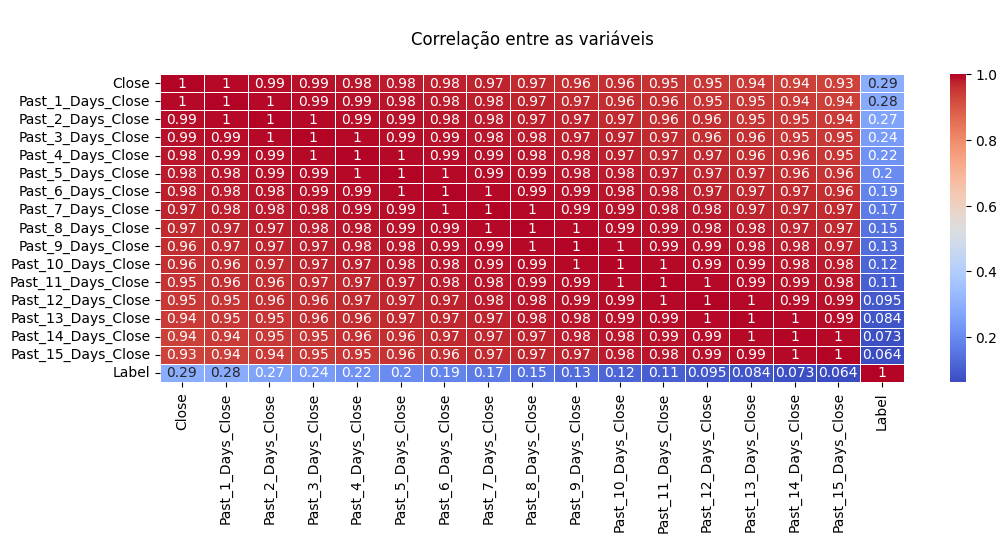

In [12]:
correlation = spec_bbas3_test.select_dtypes("number").corr()

plt.figure(figsize=(12, 4))

sns.heatmap(
    correlation, 
    annot=True, 
    annot_kws={"size" : 10},
    cmap="coolwarm",
    cbar=True,
    linewidths=0.5,
    linecolor="white"
)

plt.title("\nCorrelação entre as variáveis\n", fontdict={"size" : 12})

plt.show()

Além disso, note que as mesmas observações realizadas na matriz de correlação das variáveis do conjunto de treino também estão presentes no conjunto de teste, ou seja, mesmo que baixa, há uma correlação entre a variável alvo e o valor do fechamento das ações nos últimos 15 dias.

#### Modelagem e avaliação dos resultados

In [13]:
print(f"Valores possíveis da variável alvo nos conjuntos de:\n -> Treino: {list(spec_bbas3_train['Label'].unique())}\n -> Teste: {list(spec_bbas3_test['Label'].unique())}")

Valores possíveis da variável alvo nos conjuntos de:
 -> Treino: [-1, 1]
 -> Teste: [-1, 1]


Como apresentado anteriormente, a variável alvo pode assumir os valores do intervalo [-1, 1], o que pode ser um problema ao utilizarmos a função de ativação sigmoid (que assume valores no intervalo [0, 1]), sendo assim, substituímos os valores -1 por 0.

In [14]:
spec_bbas3_train["Label"] = spec_bbas3_train["Label"].apply(lambda x: 0 if x == -1 else 1)
spec_bbas3_test["Label"] = spec_bbas3_test["Label"].apply(lambda x: 0 if x == -1 else 1)
print(f"Valores possíveis da variável alvo nos conjuntos de:\n -> Treino: {list(spec_bbas3_train['Label'].unique())}\n -> Teste: {list(spec_bbas3_test['Label'].unique())}")

Valores possíveis da variável alvo nos conjuntos de:
 -> Treino: [0, 1]
 -> Teste: [0, 1]


Feito isso, iremos realizar quatro testes para o baseline: sem normalizações, com standard scalling, com minmax scalling e com robust scalling. Para isso serão construídas as variáveis "x", "x_standard", "x_minmax" e "x_robust".

In [15]:
x_train_bbas3 = np.array(spec_bbas3_train.drop(columns=["Label"]))
x_test_bbas3 = np.array(spec_bbas3_test.drop(columns=["Label"]))

x_standard_train_bbas3 = np.array(StandardScaler().fit_transform(spec_bbas3_train.drop(columns=["Label"])))
x_standard_test_bbas3 = np.array(StandardScaler().fit_transform(spec_bbas3_test.drop(columns=["Label"])))

x_minmax_train_bbas3 = np.array(MinMaxScaler().fit_transform(spec_bbas3_train.drop(columns=["Label"])))
x_minmax_test_bbas3 = np.array(MinMaxScaler().fit_transform(spec_bbas3_test.drop(columns=["Label"])))

x_robust_train_bbas3 = np.array(RobustScaler().fit_transform(spec_bbas3_train.drop(columns=["Label"])))
x_robust_test_bbas3 = np.array(RobustScaler().fit_transform(spec_bbas3_test.drop(columns=["Label"])))

x_list_train_bbas3 = [["Não", x_train_bbas3], ["Standard", x_standard_train_bbas3], ["Minmax", x_minmax_train_bbas3], ["Robust", x_robust_train_bbas3]]
x_list_test_bbas3 = [["Não", x_test_bbas3], ["Standard", x_standard_test_bbas3], ["Minmax", x_minmax_test_bbas3], ["Robust", x_robust_test_bbas3]]

y_train_bbas3 = np.array(spec_bbas3_train["Label"])
y_test_bbas3 = np.array(spec_bbas3_test["Label"])

Com as variáveis independentes tratadas, podemos iniciar o desenho da topologia da rede neural. 

Optamos por seguir com o uso das LSTM (Long Short-Term Memory), visto a sua capacidade de "lembrar" de dados já processados em um determinado espaço de tempo, o que as tornam fortes candidatas para solucionar o problema que queremos resolver: comprar ou vender uma determinada ação.

Sendo assim, iremos realizar testes utilizando as camadas LSTM, Dropout e Densa variando o número de camadas (1, 2 e 3) e neurônios (16, 32 e 64) para cada conjunto X (não normalizado, standard, minmax e robust) de variáveis.

In [16]:
grid_bbas3 = [[1,16], [1,32], [1,64], [2,16], [2,32], [2,64], [3,16], [3,32], [3,64]]
grid_size_bbas3 = len(grid_bbas3)

In [17]:
# Inicializa variáveis auxiliares
network_index_bbas3 = 0

# Instancia o modelo
lstm_bbas3 = CL()

# Percorre o grid de treinos
for i in range(grid_size_bbas3):
    # Percorre a lista de normalizações de treino
    for x_i_train_bbas3, x_i_test_bbas3 in zip(x_list_train_bbas3, x_list_test_bbas3):
        # Apresenta a topologia da i-ésima rede neural
        print(f"\nTopologia: {network_index_bbas3}\n -> {grid_bbas3[i][0]}x LSTM com {grid_bbas3[i][1]} neurônios\n -> {grid_bbas3[i][0]}x Dropout com rate de {round(0.1 * grid_bbas3[i][0], 2)}\n -> 1x Densa\n -> Normalização: {x_i_train_bbas3[0]}")
        # Constrói, compila e treina a topologia da i-ésima rede neural
        lstm_bbas3.build_model(c_layers_number=grid_bbas3[i][0], c_units_number=grid_bbas3[i][1], c_dropout_rate=0.1, c_input_shape=(16, 1))
        lstm_bbas3.compile_model(c_optimizer="adam", c_loss="binary_crossentropy", c_metrics=["accuracy"])
        lstm_bbas3.fit_model(c_x=x_i_train_bbas3[1], c_y=y_train_bbas3, c_test_size=0.3, c_random_state=42, c_epochs_number=100, c_batches_number=64, c_verbose=0)
        lstm_bbas3.evaluate_model()
        lstm_bbas3.predict_model(c_x=x_i_test_bbas3[1])
        network_index_bbas3 += 1


Topologia: 0
 -> 1x LSTM com 16 neurônios
 -> 1x Dropout com rate de 0.1
 -> 1x Densa
 -> Normalização: Não
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7618 - loss: 0.4640
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Topologia: 1
 -> 1x LSTM com 16 neurônios
 -> 1x Dropout com rate de 0.1
 -> 1x Densa
 -> Normalização: Standard
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8142 - loss: 0.3769
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Topologia: 2
 -> 1x LSTM com 16 neurônios
 -> 1x Dropout com rate de 0.1
 -> 1x Densa
 -> Normalização: Minmax
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7444 - loss: 0.5514
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Topologia: 3
 -> 1x LSTM com 16 neurônios
 -> 1x Dropout com rate de 0.1
 -> 1x Densa
 -> Normalização: Robust
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8140 - loss: 0.3634
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Topologia: 4
 -> 1x LSTM com 32 neurônios
 -> 1x Dropout com rate de 0.1
 -> 1x Densa
 -> Normalização: 

In [18]:
# Inicializa variáveis auxiliares
champion_index_bbas3 = 0
current_loss_bbas3 = float("+inf")
current_accuracy_bbas3 = float("-inf")

# Realiza a atualização para apresentar a arquitetura mais performática
for i_bbas3 in range(len(lstm_bbas3.c_model_scores_train)):
    if lstm_bbas3.c_model_scores_train[i_bbas3][0] < current_loss_bbas3:
        current_loss_bbas3 = round(lstm_bbas3.c_model_scores_train[i_bbas3][0], 2)
        champion_index_bbas3 = i_bbas3
    if lstm_bbas3.c_model_scores_train[i_bbas3][1] > current_accuracy_bbas3:
        current_accuracy_bbas3 = round(lstm_bbas3.c_model_scores_train[i_bbas3][1], 2)
        champion_index_bbas3 = i_bbas3

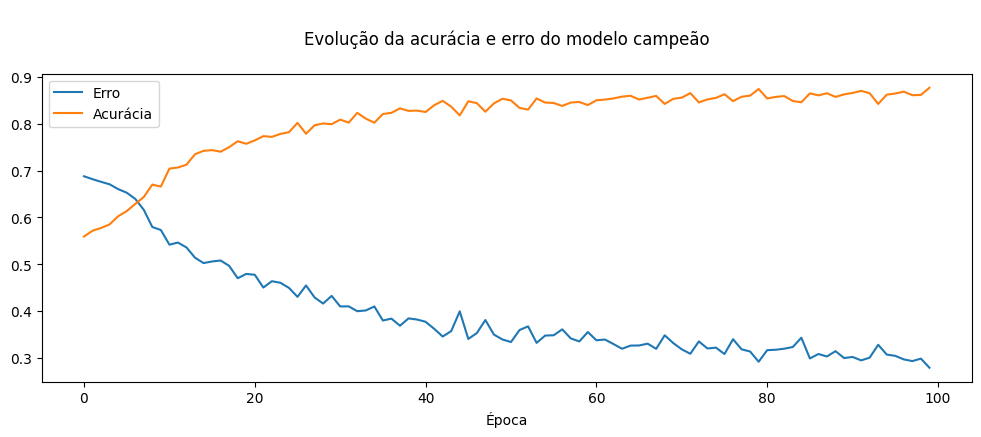

In [19]:
plt.figure(figsize=(12, 4))
plt.plot(lstm_bbas3.c_model_statistics_train[champion_index_bbas3][1])
plt.plot(lstm_bbas3.c_model_statistics_train[champion_index_bbas3][0])
plt.title("\nEvolução da acurácia e erro do modelo campeão\n")
plt.xlabel("Época")
plt.legend(["Erro", "Acurácia"], loc="upper left")
plt.show()

In [20]:
y_pred_bbas3 = (lstm_bbas3.c_predicts[champion_index_bbas3] > 0.5).astype(int)
confu_matrix_bbas3 = confusion_matrix(y_test_bbas3, y_pred_bbas3)
class_report_bbas3 = classification_report(y_test_bbas3, y_pred_bbas3)

print(f"\nInformações do modelo campeão:\n\n -> Topologia: {champion_index_bbas3}\n\n -> Acurácia: {current_accuracy_bbas3}%\n\n -> Erro: {current_loss_bbas3}%\n\n -> Matriz de confusão\n{confu_matrix_bbas3}\n\n -> Reporte de classificação\n{class_report_bbas3}")


Informações do modelo campeão:

 -> Topologia: 32

 -> Acurácia: 0.88%

 -> Erro: 0.27%

 -> Matriz de confusão
[[244 445]
 [  4 492]]

 -> Reporte de classificação
              precision    recall  f1-score   support

           0       0.98      0.35      0.52       689
           1       0.53      0.99      0.69       496

    accuracy                           0.62      1185
   macro avg       0.75      0.67      0.60      1185
weighted avg       0.79      0.62      0.59      1185



Como apresentado acima, a 32° topologia (3x LSTM com 64 neurônios + 3x Dropout com rate de 0.3 + 1x Densa + Normalização: Não) apresentou a maior acurácia dentre as demais topologias, entretanto, apegar-se apenas a essa métrica é um erro, visto que como apresentado na matriz de confusão, grande parte das predições que deveriam ser vendas foram classificadas como compras, ou seja, estaríamos perdendo dinheiro ao comprar as ações no momento que deveríamos estar vendendo.

Como hipótese inicial, entendemos que a baixa precisão para venda de ações foi ocasionada pelo desbalanceamento de classes, visto que no conjunto de treinamento a representividade foi de ~55%, enquanto que no conjunto de teste a representatividade foi de apenas 42%. 

Para validar esse ponto, realizaremos o balanceamento de classes para os demais conjuntos de dados das ações CSNA3, PETR4 e VALE3.

___

#### Leitura e análise do conjunto de treino das ações da Companhia Siderúrgica Narcional (CSNA3)

In [21]:
raw_csna3_train = pd.read_csv("_datasets/csna3/treino.csv")
raw_csna3_train.tail(5)

,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
4738,4739,2019-03-18,10.849827,9.159503,1,10.390541,10.250756,10.310663,9.432028,9.691624,9.159118,9.811440,10.084350,9.219026,8.706488,8.440235,8.779707,8.719800,8.253856,7.674757
4739,4740,2019-03-19,10.437135,9.287266,1,10.849827,10.390541,10.250756,10.310663,9.432028,9.691624,9.159118,9.811440,10.084350,9.219026,8.706488,8.440235,8.779707,8.719800,8.253856
4740,4741,2019-03-20,10.583574,9.416897,1,10.437135,10.849827,10.390541,10.250756,10.310663,9.432028,9.691624,9.159118,9.811440,10.084350,9.219026,8.706488,8.440235,8.779707,8.719800
4741,4742,2019-03-21,10.370573,9.512265,1,10.583574,10.437135,10.849827,10.390541,10.250756,10.310663,9.432028,9.691624,9.159118,9.811440,10.084350,9.219026,8.706488,8.440235,8.779707
4742,4743,2019-03-22,9.957878,9.556826,1,10.370573,10.583574,10.437135,10.849827,10.390541,10.250756,10.310663,9.432028,9.691624,9.159118,9.811440,10.084350,9.219026,8.706488,8.440235


Perceba que, ao importar o conjunto de dados de treino, podemos realizar algumas alterações para facilitar a análise e manipulação das informações.

- Remoção de variáveis

    - "Unnamed: 0" : o registro representa um índice.
    - "Date" : o registro representa a data de coleta do dado.
    - "Smoothed_Close" : o registro representa o valor suavizado do fechamento do ativo - citado como "apenas uma curiosidade".

- Ordenação das variáveis

    - Para facilitar a interpretação, iremos ordenar o conjunto de dados de treino pelas variáveis independentes seguidas da variável dependente.

In [22]:
spec_csna3_train = raw_csna3_train.drop(columns="Smoothed_Close")
spec_csna3_train = spec_csna3_train[["Close", "Past_1_Days_Close", "Past_2_Days_Close", "Past_3_Days_Close", "Past_4_Days_Close", "Past_5_Days_Close", "Past_6_Days_Close", "Past_7_Days_Close", "Past_8_Days_Close", "Past_9_Days_Close", "Past_10_Days_Close", "Past_11_Days_Close", "Past_12_Days_Close", "Past_13_Days_Close", "Past_14_Days_Close", "Past_15_Days_Close", "Label"]]
spec_csna3_train.tail(5)

,Close,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close,Label
4738,10.849827,10.390541,10.250756,10.310663,9.432028,9.691624,9.159118,9.811440,10.084350,9.219026,8.706488,8.440235,8.779707,8.719800,8.253856,7.674757,1
4739,10.437135,10.849827,10.390541,10.250756,10.310663,9.432028,9.691624,9.159118,9.811440,10.084350,9.219026,8.706488,8.440235,8.779707,8.719800,8.253856,1
4740,10.583574,10.437135,10.849827,10.390541,10.250756,10.310663,9.432028,9.691624,9.159118,9.811440,10.084350,9.219026,8.706488,8.440235,8.779707,8.719800,1
4741,10.370573,10.583574,10.437135,10.849827,10.390541,10.250756,10.310663,9.432028,9.691624,9.159118,9.811440,10.084350,9.219026,8.706488,8.440235,8.779707,1
4742,9.957878,10.370573,10.583574,10.437135,10.849827,10.390541,10.250756,10.310663,9.432028,9.691624,9.159118,9.811440,10.084350,9.219026,8.706488,8.440235,1


Com o conjunto de dados de treino ordenado e livre de variáveis que não serão utilizadas, podemos realizar a análise inicial dos dados.

In [23]:
spec_csna3_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4743 entries, 0 to 4742
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Close               4743 non-null   float64
 1   Past_1_Days_Close   4743 non-null   float64
 2   Past_2_Days_Close   4743 non-null   float64
 3   Past_3_Days_Close   4743 non-null   float64
 4   Past_4_Days_Close   4743 non-null   float64
 5   Past_5_Days_Close   4743 non-null   float64
 6   Past_6_Days_Close   4743 non-null   float64
 7   Past_7_Days_Close   4743 non-null   float64
 8   Past_8_Days_Close   4743 non-null   float64
 9   Past_9_Days_Close   4743 non-null   float64
 10  Past_10_Days_Close  4743 non-null   float64
 11  Past_11_Days_Close  4743 non-null   float64
 12  Past_12_Days_Close  4743 non-null   float64
 13  Past_13_Days_Close  4743 non-null   float64
 14  Past_14_Days_Close  4743 non-null   float64
 15  Past_15_Days_Close  4743 non-null   float64
 16  Label 

Assim como o conjunto de dados de treino com as ações do BBAS3 (Banco do Brasil), não foram identificados nenhum atributo nulo nas colunas do conjunto de dados de treino com as ações da CSNA3 (Companhia Siderúrgica Nacional), dessa forma não será necessário realizar a remoção de registros ou imputar valores para completar o conjunto de dados.

Sendo assim, como próximos passos, iremos analisar o comportamento das variáveis a fim de entender se o conjunto de dados de treino está balanceado (número de compras e vendas similar) e, em seguida, verificar a correlação entre as variáveis.

In [24]:
label_distribution = ddb.sql("""SELECT Label, COUNT(*) AS Regs from spec_csna3_train GROUP BY 1""").to_df()
size = spec_csna3_train.shape[0]
buy_count = label_distribution["Regs"][0]
sell_count = label_distribution["Regs"][1]
buy_percentual = round((buy_count / size) * 100, 2)
sell_percentual = round((sell_count / size) * 100, 2)

print(f"O conjunto de dados possui {size} registros, onde:")
print(f" -> Vendas: {buy_count} ou {buy_percentual}%")
print(f" -> Compras: {sell_count} ou {sell_percentual}%")

O conjunto de dados possui 4743 registros, onde:
 -> Vendas: 2655 ou 55.98%
 -> Compras: 2088 ou 44.02%


O conjunto de dados de treino apresenta uma inclinação para classificar vendas, sendo assim, iremos utilizar a técnica Smote para realizar o balanceamento entre as classes quando formos treinar o modelo, evitando que o modelo torne-se especialista em uma determinada classe.

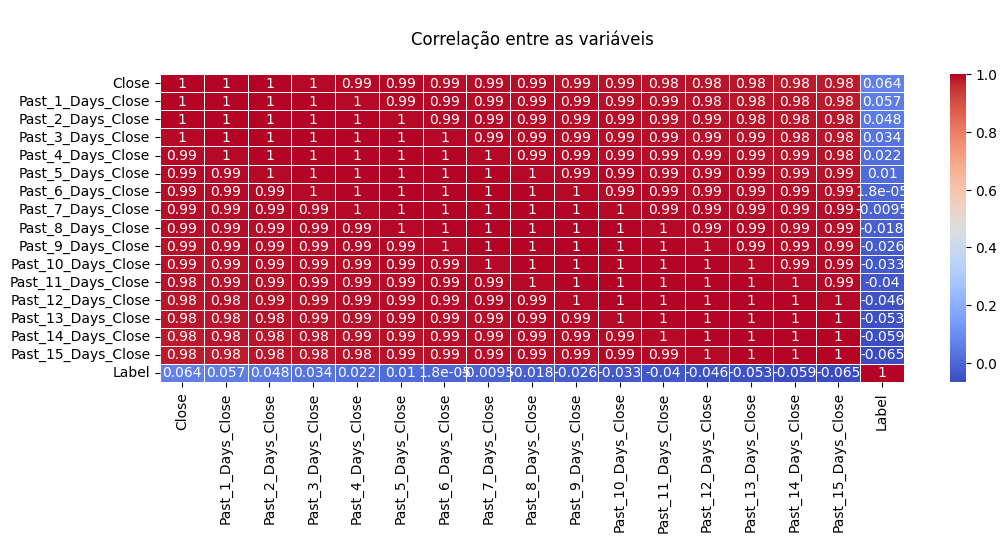

In [25]:
correlation = spec_csna3_train.select_dtypes("number").corr()

plt.figure(figsize=(12, 4))

sns.heatmap(
    correlation, 
    annot=True, 
    annot_kws={"size" : 10},
    cmap="coolwarm",
    cbar=True,
    linewidths=0.5,
    linecolor="white"
)

plt.title("\nCorrelação entre as variáveis\n", fontdict={"size" : 12})

plt.show()

Assim como apresentado no conjunto de dados de treino das ações BBAS3 (Banco do Brasil), o conjunto de dados de treino das ações CSNA3 (Companhia Siderúrgica Nacional) apresentam as seguintes características:

- Variável dependente: a correlação entre a ação de venda/compra diminui ao passar dos dias, ou seja, considerando APENAS o que é apresentado acima, poderíamos pressupor que a ação é tomada com base nos dados mais recentes, ou seja, uma janela mais curta de dias.

- Variáveis independentes: diferente da variável dependente, todas as variáveis independentes apresentam uma alta correlação entre sí, o que nos leva a pensar que o valor de fechamento em D-15 influencia em D-14 e assim sucessivamente.

Posto isso, iremos desenvolver um modelo baseline para fazer uma classificação inicial das ações.

#### Leitura e análise do conjunto de teste das ações da Companhia Siderúrgica Narcional (CSNA3)

In [26]:
raw_csna3_test = pd.read_csv("_datasets/csna3/teste.csv")
raw_csna3_test.tail(5)

,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
1181,5925,2023-12-21,19.049999,17.232923,1,18.379999,18.700001,18.530001,18.030001,17.610001,17.520000,17.150000,17.139999,17.200001,16.969999,17.129999,17.180000,17.010000,17.160000,16.420000
1182,5926,2023-12-22,19.110001,17.420631,1,19.049999,18.379999,18.700001,18.530001,18.030001,17.610001,17.520000,17.150000,17.139999,17.200001,16.969999,17.129999,17.180000,17.010000,17.160000
1183,5927,2023-12-26,19.360001,17.614568,1,19.110001,19.049999,18.379999,18.700001,18.530001,18.030001,17.610001,17.520000,17.150000,17.139999,17.200001,16.969999,17.129999,17.180000,17.010000
1184,5928,2023-12-27,19.510000,17.804111,1,19.360001,19.110001,19.049999,18.379999,18.700001,18.530001,18.030001,17.610001,17.520000,17.150000,17.139999,17.200001,16.969999,17.129999,17.180000
1185,5929,2023-12-28,19.660000,17.989700,1,19.510000,19.360001,19.110001,19.049999,18.379999,18.700001,18.530001,18.030001,17.610001,17.520000,17.150000,17.139999,17.200001,16.969999,17.129999


Para mantermos o padrão, iremos realizar os mesmos tratamentos que foram realizados no conjunto de treino no conjunto de teste, ou seja, a remoção das colunas "Unamed: 0", "Date" e "Smoothed_Close" (que não serão utilizadas no treinamento dos modelos) e a ordenação das variáveis para facilitar a leitura.

In [27]:
spec_csna3_test = raw_csna3_test.drop(columns="Smoothed_Close")
spec_csna3_test = spec_csna3_test[["Close", "Past_1_Days_Close", "Past_2_Days_Close", "Past_3_Days_Close", "Past_4_Days_Close", "Past_5_Days_Close", "Past_6_Days_Close", "Past_7_Days_Close", "Past_8_Days_Close", "Past_9_Days_Close", "Past_10_Days_Close", "Past_11_Days_Close", "Past_12_Days_Close", "Past_13_Days_Close", "Past_14_Days_Close", "Past_15_Days_Close", "Label"]]
spec_csna3_test.tail(5)

,Close,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close,Label
1181,19.049999,18.379999,18.700001,18.530001,18.030001,17.610001,17.520000,17.150000,17.139999,17.200001,16.969999,17.129999,17.180000,17.010000,17.160000,16.420000,1
1182,19.110001,19.049999,18.379999,18.700001,18.530001,18.030001,17.610001,17.520000,17.150000,17.139999,17.200001,16.969999,17.129999,17.180000,17.010000,17.160000,1
1183,19.360001,19.110001,19.049999,18.379999,18.700001,18.530001,18.030001,17.610001,17.520000,17.150000,17.139999,17.200001,16.969999,17.129999,17.180000,17.010000,1
1184,19.510000,19.360001,19.110001,19.049999,18.379999,18.700001,18.530001,18.030001,17.610001,17.520000,17.150000,17.139999,17.200001,16.969999,17.129999,17.180000,1
1185,19.660000,19.510000,19.360001,19.110001,19.049999,18.379999,18.700001,18.530001,18.030001,17.610001,17.520000,17.150000,17.139999,17.200001,16.969999,17.129999,1


Com o conjunto de dados de treino ordenado e livre de variáveis que não serão utilizadas, podemos realizar a análise inicial dos dados.

In [28]:
spec_csna3_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186 entries, 0 to 1185
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Close               1186 non-null   float64
 1   Past_1_Days_Close   1186 non-null   float64
 2   Past_2_Days_Close   1186 non-null   float64
 3   Past_3_Days_Close   1186 non-null   float64
 4   Past_4_Days_Close   1186 non-null   float64
 5   Past_5_Days_Close   1186 non-null   float64
 6   Past_6_Days_Close   1186 non-null   float64
 7   Past_7_Days_Close   1186 non-null   float64
 8   Past_8_Days_Close   1186 non-null   float64
 9   Past_9_Days_Close   1186 non-null   float64
 10  Past_10_Days_Close  1186 non-null   float64
 11  Past_11_Days_Close  1186 non-null   float64
 12  Past_12_Days_Close  1186 non-null   float64
 13  Past_13_Days_Close  1186 non-null   float64
 14  Past_14_Days_Close  1186 non-null   float64
 15  Past_15_Days_Close  1186 non-null   float64
 16  Label 

Como apresentado acima, de fato não existem dados nulos, ou seja, assim como no conjunto de treino, não precisaremos realizar nenhum tipo de exclusão ou imputação de dados no conjunto de teste.

Sendo assim, podemos verificar se o conjunto de treino é balanceado, ou seja, se não existe uma diferença significativa entre o número de registros de venda e compra de ações.

In [29]:
label_distribution = ddb.sql("""SELECT Label, COUNT(*) AS Regs from spec_csna3_test GROUP BY 1""").to_df()
size = spec_csna3_test.shape[0]
buy_count = label_distribution["Regs"][0]
sell_count = label_distribution["Regs"][1]
buy_percentual = round(buy_count / size, 2)
sell_percentual = round(sell_count / size, 2)

print(f"O conjunto de dados possui {size} registros, onde:")
print(f" -> Vendas: {buy_count} ou {buy_percentual}%")
print(f" -> Compras: {sell_count} ou {sell_percentual}%")

O conjunto de dados possui 1186 registros, onde:
 -> Vendas: 688 ou 0.58%
 -> Compras: 498 ou 0.42%


Assim como apresentado no conjunto de dados de teste das ações BBAS3 (Banco do Brasil), o conjunto de dados de teste das ações CSNA3 (Companhia Siderúrgica Nacional) apresentam uma diferença significativa na distribuição das classes, entretanto, como utilizaremos a técnica SMOTE para realizar o treinamento, espera-se que o modelo apresente bons resultados e não crie viés para uma das classes.

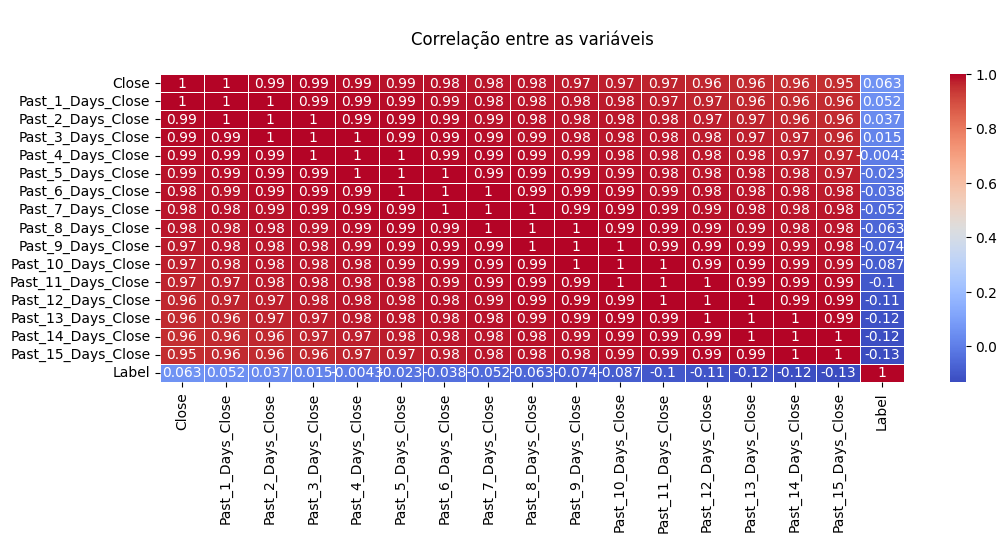

In [30]:
correlation = spec_csna3_test.select_dtypes("number").corr()

plt.figure(figsize=(12, 4))

sns.heatmap(
    correlation, 
    annot=True, 
    annot_kws={"size" : 10},
    cmap="coolwarm",
    cbar=True,
    linewidths=0.5,
    linecolor="white"
)

plt.title("\nCorrelação entre as variáveis\n", fontdict={"size" : 12})

plt.show()

Perceba que, após analisarmos a matriz de correlação do conjunto de dados de teste, observamos um comportamento semelhante a matriz de correlação do conjunto de dados de treino, ou seja, uma baixíssima correlação entre a variável dependente e as variáveis independentes.

#### Modelagem e avaliação dos resultados

In [31]:
print(f"Valores possíveis da variável alvo nos conjuntos de:\n -> Treino: {list(spec_csna3_train['Label'].unique())}\n -> Teste: {list(spec_csna3_test['Label'].unique())}")

Valores possíveis da variável alvo nos conjuntos de:
 -> Treino: [-1, 1]
 -> Teste: [1, -1]


Como apresentado anteriormente, a variável alvo pode assumir os valores do intervalo [-1, 1], o que pode ser um problema ao utilizarmos a função de ativação sigmoid (que assume valores no intervalo [0, 1]), sendo assim, substituímos os valores -1 por 0.

In [32]:
spec_csna3_train["Label"] = spec_csna3_train["Label"].apply(lambda x: 0 if x == -1 else 1)
spec_csna3_test["Label"] = spec_csna3_test["Label"].apply(lambda x: 0 if x == -1 else 1)
print(f"Valores possíveis da variável alvo nos conjuntos de:\n -> Treino: {list(spec_csna3_train['Label'].unique())}\n -> Teste: {list(spec_csna3_test['Label'].unique())}")

Valores possíveis da variável alvo nos conjuntos de:
 -> Treino: [0, 1]
 -> Teste: [1, 0]


Feito isso, iremos realizar quatro testes para o baseline: sem normalizações, com standard scalling, com minmax scalling e com robust scalling. Para isso serão construídas as variáveis "x", "x_standard", "x_minmax" e "x_robust".

In [33]:
# Instancia o SMOTE para realizar o balanceamento das classes do conjunto de treino
smote = SMOTE(sampling_strategy="auto", random_state=42)

x_train_csna3 = np.array(spec_csna3_train.drop(columns=["Label"]))
x_test_csna3 = np.array(spec_csna3_test.drop(columns=["Label"]))

y_train_csna3 = np.array(spec_csna3_train["Label"])
y_test_csna3 = np.array(spec_csna3_test["Label"])

# Realiza o balanceamento de classes dos conjuntos do conjunto de treino
x_train_csna3, y_train_csna3 = smote.fit_resample(x_train_csna3, y_train_csna3)

x_standard_train_csna3 = np.array(StandardScaler().fit_transform(x_train_csna3))
x_standard_test_csna3 = np.array(StandardScaler().fit_transform(x_test_csna3))

x_minmax_train_csna3 = np.array(MinMaxScaler().fit_transform(x_train_csna3))
x_minmax_test_csna3 = np.array(MinMaxScaler().fit_transform(x_test_csna3))

x_robust_train_csna3 = np.array(RobustScaler().fit_transform(x_train_csna3))
x_robust_test_csna3 = np.array(RobustScaler().fit_transform(x_test_csna3))

x_list_train_csna3 = [["Não", x_train_csna3], ["Standard", x_standard_train_csna3], ["Minmax", x_minmax_train_csna3], ["Robust", x_robust_train_csna3]]
x_list_test_csna3 = [["Não", x_test_csna3], ["Standard", x_standard_test_csna3], ["Minmax", x_minmax_test_csna3], ["Robust", x_robust_test_csna3]]

Com as variáveis independentes tratadas, podemos iniciar o desenho da topologia da rede neural. 

Optamos por seguir com o uso das LSTM (Long Short-Term Memory), visto a sua capacidade de "lembrar" de dados já processados em um determinado espaço de tempo, o que as tornam fortes candidatas para solucionar o problema que queremos resolver: comprar ou vender uma determinada ação.

Sendo assim, iremos realizar testes utilizando as camadas LSTM, Dropout e Densa variando o número de camadas (1, 2 e 3) e neurônios (16, 32 e 64) para cada conjunto X (não normalizado, standard, minmax e robust) de variáveis.

In [34]:
grid_csna3 = [[1,16], [1,32], [1,64], [2,16], [2,32], [2,64], [3,16], [3,32], [3,64]]
grid_size_csna3 = len(grid_csna3)

In [35]:
# Inicializa variáveis auxiliares
network_index_csna3 = 0

# Instancia o modelo
lstm_csna3 = CL()

# Percorre o grid de treinos
for i in range(grid_size_csna3):
    # Percorre a lista de normalizações de treino
    for x_i_train_csna3, x_i_test_csna3 in zip(x_list_train_csna3, x_list_test_csna3):
        # Apresenta a topologia da i-ésima rede neural
        print(f"\nTopologia: {network_index_csna3}\n -> {grid_csna3[i][0]}x LSTM com {grid_csna3[i][1]} neurônios\n -> {grid_csna3[i][0]}x Dropout com rate de {round(0.1 * grid_csna3[i][0], 2)}\n -> 1x Densa\n -> Normalização: {x_i_train_csna3[0]}")
        # Constrói, compila e treina a topologia da i-ésima rede neural
        lstm_csna3.build_model(c_layers_number=grid_csna3[i][0], c_units_number=grid_csna3[i][1], c_dropout_rate=0.1, c_input_shape=(16, 1))
        lstm_csna3.compile_model(c_optimizer="adam", c_loss="binary_crossentropy", c_metrics=["accuracy"])
        lstm_csna3.fit_model(c_x=x_i_train_csna3[1], c_y=y_train_csna3, c_test_size=0.3, c_random_state=42, c_epochs_number=100, c_batches_number=64, c_verbose=0)
        lstm_csna3.evaluate_model()
        lstm_csna3.predict_model(c_x=x_i_test_csna3[1])
        network_index_csna3 += 1


Topologia: 0
 -> 1x LSTM com 16 neurônios
 -> 1x Dropout com rate de 0.1
 -> 1x Densa
 -> Normalização: Não
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8567 - loss: 0.3319
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Topologia: 1
 -> 1x LSTM com 16 neurônios
 -> 1x Dropout com rate de 0.1
 -> 1x Densa
 -> Normalização: Standard
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8925 - loss: 0.2627
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Topologia: 2
 -> 1x LSTM com 16 neurônios
 -> 1x Dropout com rate de 0.1
 -> 1x Densa
 -> Normalização: Minmax
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7754 - loss: 0.4346
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Topologia: 3
 -> 1x LSTM com 16 neurônios
 -> 1x Dropout com rate de 0.1
 -> 1x Densa
 -> Normalização: Robust
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8879 - loss: 0.2749
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Topologia: 4
 -> 1x LSTM com 32 neurônios
 -> 1x Dropout com rate de 0.1
 -> 1x Densa
 -> Normalização: 

In [36]:
# Inicializa variáveis auxiliares
champion_index_csna3 = 0
current_loss_csna3 = float("+inf")
current_accuracy_csna3 = float("-inf")

# Realiza a atualização para apresentar a arquitetura mais performática
for i_csna3 in range(len(lstm_csna3.c_model_scores_train)):
    if lstm_csna3.c_model_scores_train[i_csna3][0] < current_loss_csna3:
        current_loss_csna3 = round(lstm_csna3.c_model_scores_train[i_csna3][0], 2)
        champion_index_csna3 = i_csna3
    if lstm_csna3.c_model_scores_train[i_csna3][1] > current_accuracy_csna3:
        current_accuracy_csna3 = round(lstm_csna3.c_model_scores_train[i_csna3][1], 2)
        champion_index_csna3 = i_csna3

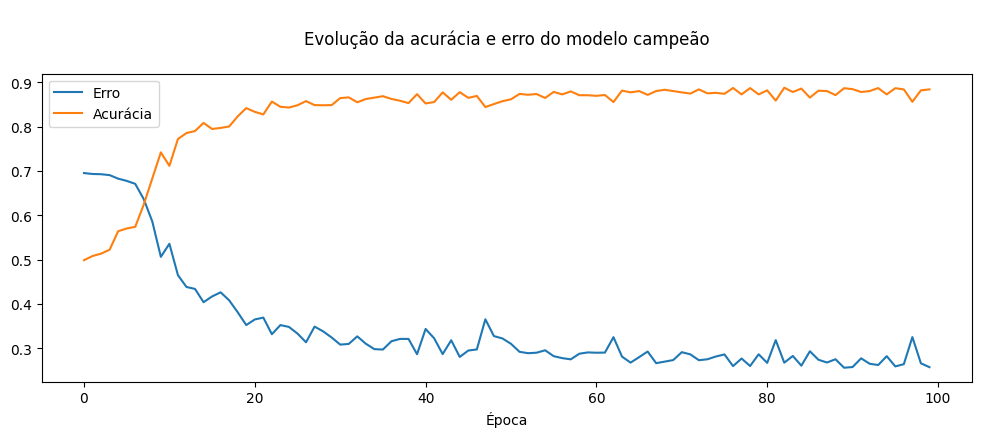

In [37]:
plt.figure(figsize=(12, 4))
plt.plot(lstm_csna3.c_model_statistics_train[champion_index_csna3][1])
plt.plot(lstm_csna3.c_model_statistics_train[champion_index_csna3][0])
plt.title("\nEvolução da acurácia e erro do modelo campeão\n")
plt.xlabel("Época")
plt.legend(["Erro", "Acurácia"], loc="upper left")
plt.show()

In [38]:
y_pred_csna3 = (lstm_csna3.c_predicts[champion_index_csna3] > 0.5).astype(int)
confu_matrix_csna3 = confusion_matrix(y_test_csna3, y_pred_csna3)
class_report_csna3 = classification_report(y_test_csna3, y_pred_csna3)

print(f"\nInformações do modelo campeão:\n\n -> Topologia: {champion_index_csna3}\n\n -> Acurácia: {current_accuracy_csna3}%\n\n -> Erro: {current_loss_csna3}%\n\n -> Matriz de confusão\n{confu_matrix_csna3}\n\n -> Reporte de classificação\n{class_report_csna3}")


Informações do modelo campeão:

 -> Topologia: 32

 -> Acurácia: 0.9%

 -> Erro: 0.23%

 -> Matriz de confusão
[[640  48]
 [200 298]]

 -> Reporte de classificação
              precision    recall  f1-score   support

           0       0.76      0.93      0.84       688
           1       0.86      0.60      0.71       498

    accuracy                           0.79      1186
   macro avg       0.81      0.76      0.77      1186
weighted avg       0.80      0.79      0.78      1186



Por uma coincidência, a 32° topologia (3x LSTM com 64 neurônios + 3x Dropout com rate de 0.3 + 1x Densa + Normalização: Não), a mesma utilizada para treinar a rede das ações BBAS3, também atingiu a maior acurácia para realizar o treinamento com as ações da CSNA3.

Além disso, notamos que devido ao balanceamento de classes (realizado utilizando o SMOTE) tivemos uma mudança significativa quando comparamos os resultados das ações BBAS3 (~38% classificações incorretas) e CSNA3 (~20% classificações incorretas), visto que na última matriz de confusão temos menos Falsos Positivos e Falsos Negativos.

Entretanto, vale ressaltar que nesse cenário estaríamos vendendo em um momento mais oportuno para compras, ou seja, em parte significativa do problema estaríamos perdendo dinheiro.

___

#### Leitura e análise do conjunto de treino das ações da Petrobras (PETR4)

In [39]:
raw_petr4_train = pd.read_csv("_datasets/petr4/treino.csv")
raw_petr4_train.tail(5)

,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
4803,4804,2019-02-19,9.752899,9.225479,1,9.532050,9.560549,9.599731,9.279146,9.161598,8.848140,8.951439,8.937191,9.079673,9.289832,9.272022,9.190095,9.111729,9.125979,9.036926
4804,4805,2019-02-20,9.631790,9.266110,1,9.752899,9.532050,9.560549,9.599731,9.279146,9.161598,8.848140,8.951439,8.937191,9.079673,9.289832,9.272022,9.190095,9.111729,9.125979
4805,4806,2019-02-21,9.760024,9.315501,1,9.631790,9.752899,9.532050,9.560549,9.599731,9.279146,9.161598,8.848140,8.951439,8.937191,9.079673,9.289832,9.272022,9.190095,9.111729
4806,4807,2019-02-22,9.663848,9.350336,1,9.760024,9.631790,9.752899,9.532050,9.560549,9.599731,9.279146,9.161598,8.848140,8.951439,8.937191,9.079673,9.289832,9.272022,9.190095
4807,4808,2019-02-25,9.510681,9.366371,1,9.663848,9.760024,9.631790,9.752899,9.532050,9.560549,9.599731,9.279146,9.161598,8.848140,8.951439,8.937191,9.079673,9.289832,9.272022


Perceba que, ao importar o conjunto de dados de treino, podemos realizar algumas alterações para facilitar a análise e manipulação das informações.

- Remoção de variáveis

    - "Unnamed: 0" : o registro representa um índice.
    - "Date" : o registro representa a data de coleta do dado.
    - "Smoothed_Close" : o registro representa o valor suavizado do fechamento do ativo - citado como "apenas uma curiosidade".

- Ordenação das variáveis

    - Para facilitar a interpretação, iremos ordenar o conjunto de dados de treino pelas variáveis independentes seguidas da variável dependente.

In [40]:
spec_petr4_train = raw_petr4_train.drop(columns="Smoothed_Close")
spec_petr4_train = spec_petr4_train[["Close", "Past_1_Days_Close", "Past_2_Days_Close", "Past_3_Days_Close", "Past_4_Days_Close", "Past_5_Days_Close", "Past_6_Days_Close", "Past_7_Days_Close", "Past_8_Days_Close", "Past_9_Days_Close", "Past_10_Days_Close", "Past_11_Days_Close", "Past_12_Days_Close", "Past_13_Days_Close", "Past_14_Days_Close", "Past_15_Days_Close", "Label"]]
spec_petr4_train.tail(5)

,Close,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close,Label
4803,9.752899,9.532050,9.560549,9.599731,9.279146,9.161598,8.848140,8.951439,8.937191,9.079673,9.289832,9.272022,9.190095,9.111729,9.125979,9.036926,1
4804,9.631790,9.752899,9.532050,9.560549,9.599731,9.279146,9.161598,8.848140,8.951439,8.937191,9.079673,9.289832,9.272022,9.190095,9.111729,9.125979,1
4805,9.760024,9.631790,9.752899,9.532050,9.560549,9.599731,9.279146,9.161598,8.848140,8.951439,8.937191,9.079673,9.289832,9.272022,9.190095,9.111729,1
4806,9.663848,9.760024,9.631790,9.752899,9.532050,9.560549,9.599731,9.279146,9.161598,8.848140,8.951439,8.937191,9.079673,9.289832,9.272022,9.190095,1
4807,9.510681,9.663848,9.760024,9.631790,9.752899,9.532050,9.560549,9.599731,9.279146,9.161598,8.848140,8.951439,8.937191,9.079673,9.289832,9.272022,1


Com o conjunto de dados de treino ordenado e livre de variáveis que não serão utilizadas, podemos realizar a análise inicial dos dados.

In [41]:
spec_petr4_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4808 entries, 0 to 4807
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Close               4808 non-null   float64
 1   Past_1_Days_Close   4808 non-null   float64
 2   Past_2_Days_Close   4808 non-null   float64
 3   Past_3_Days_Close   4808 non-null   float64
 4   Past_4_Days_Close   4808 non-null   float64
 5   Past_5_Days_Close   4808 non-null   float64
 6   Past_6_Days_Close   4808 non-null   float64
 7   Past_7_Days_Close   4808 non-null   float64
 8   Past_8_Days_Close   4808 non-null   float64
 9   Past_9_Days_Close   4808 non-null   float64
 10  Past_10_Days_Close  4808 non-null   float64
 11  Past_11_Days_Close  4808 non-null   float64
 12  Past_12_Days_Close  4808 non-null   float64
 13  Past_13_Days_Close  4808 non-null   float64
 14  Past_14_Days_Close  4808 non-null   float64
 15  Past_15_Days_Close  4808 non-null   float64
 16  Label 

Assim como o conjunto de dados de treino com as ações da CSNA3 (Companhia Siderúrgica Nacional), não foram identificados nenhum atributo nulo nas colunas do conjunto de dados de treino com as ações da Petrobras (PETR4), dessa forma não será necessário realizar a remoção de registros ou imputar valores para completar o conjunto de dados.

Sendo assim, como próximos passos, iremos analisar o comportamento das variáveis a fim de entender se o conjunto de dados de treino está balanceado (número de compras e vendas similar) e, em seguida, verificar a correlação entre as variáveis.

In [42]:
label_distribution = ddb.sql("""SELECT Label, COUNT(*) AS Regs from spec_petr4_train GROUP BY 1""").to_df()
size = spec_petr4_train.shape[0]
buy_count = label_distribution["Regs"][0]
sell_count = label_distribution["Regs"][1]
buy_percentual = round((buy_count / size) * 100, 2)
sell_percentual = round((sell_count / size) * 100, 2)

print(f"O conjunto de dados possui {size} registros, onde:")
print(f" -> Vendas: {buy_count} ou {buy_percentual}%")
print(f" -> Compras: {sell_count} ou {sell_percentual}%")

O conjunto de dados possui 4808 registros, onde:
 -> Vendas: 2654 ou 55.2%
 -> Compras: 2154 ou 44.8%


O conjunto de dados de treino apresenta uma inclinação para classificar vendas, sendo assim, iremos utilizar a técnica Smote para realizar o balanceamento entre as classes quando formos treinar o modelo, evitando que o modelo torne-se especialista em uma determinada classe.

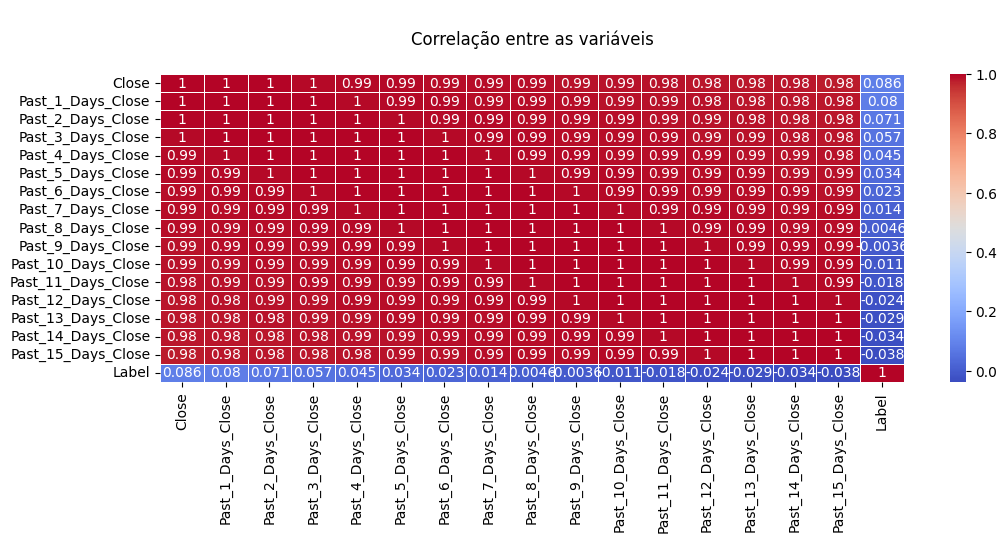

In [43]:
correlation = spec_petr4_train.select_dtypes("number").corr()

plt.figure(figsize=(12, 4))

sns.heatmap(
    correlation, 
    annot=True, 
    annot_kws={"size" : 10},
    cmap="coolwarm",
    cbar=True,
    linewidths=0.5,
    linecolor="white"
)

plt.title("\nCorrelação entre as variáveis\n", fontdict={"size" : 12})

plt.show()

Assim como apresentado no conjunto de dados de treino das ações CSNA3 (Companhia Siderúrgica Nacional), o conjunto de dados de treino das ações PETR4 (Petrobras) apresentam as seguintes características:

- Variável dependente: a correlação entre a ação de venda/compra diminui ao passar dos dias, ou seja, considerando APENAS o que é apresentado acima, poderíamos pressupor que a ação é tomada com base nos dados mais recentes, ou seja, uma janela mais curta de dias.

- Variáveis independentes: diferente da variável dependente, todas as variáveis independentes apresentam uma alta correlação entre sí, o que nos leva a pensar que o valor de fechamento em D-15 influencia em D-14 e assim sucessivamente.

Posto isso, iremos desenvolver um modelo baseline para fazer uma classificação inicial das ações.

#### Leitura e análise do conjunto de teste das ações da Petrobras (PETR4)

In [44]:
raw_petr4_test = pd.read_csv("_datasets/petr4/teste.csv")
raw_petr4_test.tail(5)

,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
1198,6007,2023-12-21,36.389999,35.241338,1,36.380001,36.250000,35.840000,35.400002,35.320000,34.570000,34.080002,34.360001,34.490002,33.419998,33.500000,34.750000,34.910000,35.669998,35.910000
1199,6008,2023-12-22,36.740002,35.391204,1,36.389999,36.380001,36.250000,35.840000,35.400002,35.320000,34.570000,34.080002,34.360001,34.490002,33.419998,33.500000,34.750000,34.910000,35.669998
1200,6009,2023-12-26,37.330002,35.585084,1,36.740002,36.389999,36.380001,36.250000,35.840000,35.400002,35.320000,34.570000,34.080002,34.360001,34.490002,33.419998,33.500000,34.750000,34.910000
1201,6010,2023-12-27,37.360001,35.762576,1,37.330002,36.740002,36.389999,36.380001,36.250000,35.840000,35.400002,35.320000,34.570000,34.080002,34.360001,34.490002,33.419998,33.500000,34.750000
1202,6011,2023-12-28,37.240002,35.910318,1,37.360001,37.330002,36.740002,36.389999,36.380001,36.250000,35.840000,35.400002,35.320000,34.570000,34.080002,34.360001,34.490002,33.419998,33.500000


Para mantermos o padrão, iremos realizar os mesmos tratamentos que foram realizados no conjunto de treino no conjunto de teste, ou seja, a remoção das colunas "Unamed: 0", "Date" e "Smoothed_Close" (que não serão utilizadas no treinamento dos modelos) e a ordenação das variáveis para facilitar a leitura.

In [45]:
spec_petr4_test = raw_petr4_test.drop(columns="Smoothed_Close")
spec_petr4_test = spec_petr4_test[["Close", "Past_1_Days_Close", "Past_2_Days_Close", "Past_3_Days_Close", "Past_4_Days_Close", "Past_5_Days_Close", "Past_6_Days_Close", "Past_7_Days_Close", "Past_8_Days_Close", "Past_9_Days_Close", "Past_10_Days_Close", "Past_11_Days_Close", "Past_12_Days_Close", "Past_13_Days_Close", "Past_14_Days_Close", "Past_15_Days_Close", "Label"]]
spec_petr4_test.tail(5)

,Close,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close,Label
1198,36.389999,36.380001,36.250000,35.840000,35.400002,35.320000,34.570000,34.080002,34.360001,34.490002,33.419998,33.500000,34.750000,34.910000,35.669998,35.910000,1
1199,36.740002,36.389999,36.380001,36.250000,35.840000,35.400002,35.320000,34.570000,34.080002,34.360001,34.490002,33.419998,33.500000,34.750000,34.910000,35.669998,1
1200,37.330002,36.740002,36.389999,36.380001,36.250000,35.840000,35.400002,35.320000,34.570000,34.080002,34.360001,34.490002,33.419998,33.500000,34.750000,34.910000,1
1201,37.360001,37.330002,36.740002,36.389999,36.380001,36.250000,35.840000,35.400002,35.320000,34.570000,34.080002,34.360001,34.490002,33.419998,33.500000,34.750000,1
1202,37.240002,37.360001,37.330002,36.740002,36.389999,36.380001,36.250000,35.840000,35.400002,35.320000,34.570000,34.080002,34.360001,34.490002,33.419998,33.500000,1


Com o conjunto de dados de treino ordenado e livre de variáveis que não serão utilizadas, podemos realizar a análise inicial dos dados.

In [46]:
spec_petr4_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1203 entries, 0 to 1202
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Close               1203 non-null   float64
 1   Past_1_Days_Close   1203 non-null   float64
 2   Past_2_Days_Close   1203 non-null   float64
 3   Past_3_Days_Close   1203 non-null   float64
 4   Past_4_Days_Close   1203 non-null   float64
 5   Past_5_Days_Close   1203 non-null   float64
 6   Past_6_Days_Close   1203 non-null   float64
 7   Past_7_Days_Close   1203 non-null   float64
 8   Past_8_Days_Close   1203 non-null   float64
 9   Past_9_Days_Close   1203 non-null   float64
 10  Past_10_Days_Close  1203 non-null   float64
 11  Past_11_Days_Close  1203 non-null   float64
 12  Past_12_Days_Close  1203 non-null   float64
 13  Past_13_Days_Close  1203 non-null   float64
 14  Past_14_Days_Close  1203 non-null   float64
 15  Past_15_Days_Close  1203 non-null   float64
 16  Label 

Como apresentado acima, de fato não existem dados nulos, ou seja, assim como no conjunto de treino, não precisaremos realizar nenhum tipo de exclusão ou imputação de dados no conjunto de teste.

Sendo assim, podemos verificar se o conjunto de treino é balanceado, ou seja, se não existe uma diferença significativa entre o número de registros de venda e compra de ações.

In [47]:
label_distribution = ddb.sql("""SELECT Label, COUNT(*) AS Regs from spec_petr4_test GROUP BY 1""").to_df()
size = spec_petr4_test.shape[0]
buy_count = label_distribution["Regs"][0]
sell_count = label_distribution["Regs"][1]
buy_percentual = round(buy_count / size, 2)
sell_percentual = round(sell_count / size, 2)

print(f"O conjunto de dados possui {size} registros, onde:")
print(f" -> Vendas: {buy_count} ou {buy_percentual}%")
print(f" -> Compras: {sell_count} ou {sell_percentual}%")

O conjunto de dados possui 1203 registros, onde:
 -> Vendas: 622 ou 0.52%
 -> Compras: 581 ou 0.48%


Diferentemente do comportamento apresentado no conjunto de dados de teste das ações CSNA3 (Companhia Siderúrgica Nacional), o conjunto de dados de teste das ações PETR4 (Petrobras) apresentam uma pequena diferença na distribuição das classes, entretanto, como a distribuição no conjunto de dados de treinamento foi alta, seguiremos com a aplicação da técnica SMOTE para realizar o treinamento.

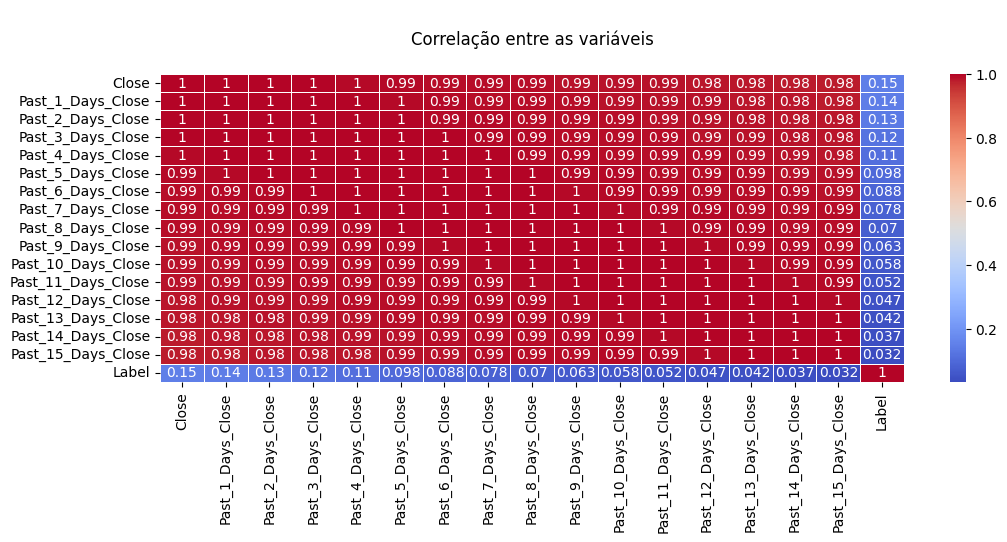

In [48]:
correlation = spec_petr4_test.select_dtypes("number").corr()

plt.figure(figsize=(12, 4))

sns.heatmap(
    correlation, 
    annot=True, 
    annot_kws={"size" : 10},
    cmap="coolwarm",
    cbar=True,
    linewidths=0.5,
    linecolor="white"
)

plt.title("\nCorrelação entre as variáveis\n", fontdict={"size" : 12})

plt.show()

Perceba que, após analisarmos a matriz de correlação do conjunto de dados de teste, observamos um comportamento semelhante a matriz de correlação do conjunto de dados de treino, ou seja, uma baixíssima correlação entre a variável dependente e as variáveis independentes.

#### Modelagem e avaliação dos resultados

In [49]:
print(f"Valores possíveis da variável alvo nos conjuntos de:\n -> Treino: {list(spec_petr4_train['Label'].unique())}\n -> Teste: {list(spec_petr4_test['Label'].unique())}")

Valores possíveis da variável alvo nos conjuntos de:
 -> Treino: [-1, 1]
 -> Teste: [1, -1]


Como apresentado anteriormente, a variável alvo pode assumir os valores do intervalo [-1, 1], o que pode ser um problema ao utilizarmos a função de ativação sigmoid (que assume valores no intervalo [0, 1]), sendo assim, substituímos os valores -1 por 0.

In [50]:
spec_petr4_train["Label"] = spec_petr4_train["Label"].apply(lambda x: 0 if x == -1 else 1)
spec_petr4_test["Label"] = spec_petr4_test["Label"].apply(lambda x: 0 if x == -1 else 1)
print(f"Valores possíveis da variável alvo nos conjuntos de:\n -> Treino: {list(spec_petr4_train['Label'].unique())}\n -> Teste: {list(spec_petr4_test['Label'].unique())}")

Valores possíveis da variável alvo nos conjuntos de:
 -> Treino: [0, 1]
 -> Teste: [1, 0]


Feito isso, iremos realizar quatro testes para o baseline: sem normalizações, com standard scalling, com minmax scalling e com robust scalling. Para isso serão construídas as variáveis "x", "x_standard", "x_minmax" e "x_robust".

In [51]:
# Instancia o SMOTE para realizar o balanceamento das classes do conjunto de treino
smote = SMOTE(sampling_strategy="auto", random_state=42)

x_train_petr4 = np.array(spec_petr4_train.drop(columns=["Label"]))
x_test_petr4 = np.array(spec_petr4_test.drop(columns=["Label"]))

y_train_petr4 = np.array(spec_petr4_train["Label"])
y_test_petr4 = np.array(spec_petr4_test["Label"])

# Realiza o balanceamento de classes dos conjuntos do conjunto de treino
x_train_petr4, y_train_petr4 = smote.fit_resample(x_train_petr4, y_train_petr4)

x_standard_train_petr4 = np.array(StandardScaler().fit_transform(x_train_petr4))
x_standard_test_petr4 = np.array(StandardScaler().fit_transform(x_test_petr4))

x_minmax_train_petr4 = np.array(MinMaxScaler().fit_transform(x_train_petr4))
x_minmax_test_petr4 = np.array(MinMaxScaler().fit_transform(x_test_petr4))

x_robust_train_petr4 = np.array(RobustScaler().fit_transform(x_train_petr4))
x_robust_test_petr4 = np.array(RobustScaler().fit_transform(x_test_petr4))

x_list_train_petr4 = [["Não", x_train_petr4], ["Standard", x_standard_train_petr4], ["Minmax", x_minmax_train_petr4], ["Robust", x_robust_train_petr4]]
x_list_test_petr4 = [["Não", x_test_petr4], ["Standard", x_standard_test_petr4], ["Minmax", x_minmax_test_petr4], ["Robust", x_robust_test_petr4]]

Com as variáveis independentes tratadas, podemos iniciar o desenho da topologia da rede neural. 

Optamos por seguir com o uso das LSTM (Long Short-Term Memory), visto a sua capacidade de "lembrar" de dados já processados em um determinado espaço de tempo, o que as tornam fortes candidatas para solucionar o problema que queremos resolver: comprar ou vender uma determinada ação.

Sendo assim, iremos realizar testes utilizando as camadas LSTM, Dropout e Densa variando o número de camadas (1, 2 e 3) e neurônios (16, 32 e 64) para cada conjunto X (não normalizado, standard, minmax e robust) de variáveis.

In [52]:
grid_petr4 = [[1,16], [1,32], [1,64], [2,16], [2,32], [2,64], [3,16], [3,32], [3,64]]
grid_size_petr4 = len(grid_petr4)

In [53]:
# Inicializa variáveis auxiliares
network_index_petr4 = 0

# Instancia o modelo
lstm_petr4 = CL()

# Percorre o grid de treinos
for i in range(grid_size_petr4):
    # Percorre a lista de normalizações de treino
    for x_i_train_petr4, x_i_test_petr4 in zip(x_list_train_petr4, x_list_test_petr4):
        # Apresenta a topologia da i-ésima rede neural
        print(f"\nTopologia: {network_index_petr4}\n -> {grid_petr4[i][0]}x LSTM com {grid_petr4[i][1]} neurônios\n -> {grid_petr4[i][0]}x Dropout com rate de {round(0.1 * grid_petr4[i][0], 2)}\n -> 1x Densa\n -> Normalização: {x_i_train_petr4[0]}")
        # Constrói, compila e treina a topologia da i-ésima rede neural
        lstm_petr4.build_model(c_layers_number=grid_petr4[i][0], c_units_number=grid_petr4[i][1], c_dropout_rate=0.1, c_input_shape=(16, 1))
        lstm_petr4.compile_model(c_optimizer="adam", c_loss="binary_crossentropy", c_metrics=["accuracy"])
        lstm_petr4.fit_model(c_x=x_i_train_petr4[1], c_y=y_train_petr4, c_test_size=0.3, c_random_state=42, c_epochs_number=100, c_batches_number=64, c_verbose=0)
        lstm_petr4.evaluate_model()
        lstm_petr4.predict_model(c_x=x_i_test_petr4[1])
        network_index_petr4 += 1


Topologia: 0
 -> 1x LSTM com 16 neurônios
 -> 1x Dropout com rate de 0.1
 -> 1x Densa
 -> Normalização: Não
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7984 - loss: 0.4167
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Topologia: 1
 -> 1x LSTM com 16 neurônios
 -> 1x Dropout com rate de 0.1
 -> 1x Densa
 -> Normalização: Standard
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8539 - loss: 0.3199
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Topologia: 2
 -> 1x LSTM com 16 neurônios
 -> 1x Dropout com rate de 0.1
 -> 1x Densa
 -> Normalização: Minmax
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7893 - loss: 0.4569
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Topologia: 3
 -> 1x LSTM com 16 neurônios
 -> 1x Dropout com rate de 0.1
 -> 1x Densa
 -> Normalização: Robust
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8764 - loss: 0.2932
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Topologia: 4
 -> 1x LSTM com 32 neurônios
 -> 1x Dropout com rate de 0.1
 -> 1x Densa
 -> Normalização: 

In [54]:
# Inicializa variáveis auxiliares
champion_index_petr4 = 0
current_loss_petr4 = float("+inf")
current_accuracy_petr4 = float("-inf")

# Realiza a atualização para apresentar a arquitetura mais performática
for i_petr4 in range(len(lstm_petr4.c_model_scores_train)):
    if lstm_petr4.c_model_scores_train[i_petr4][0] < current_loss_petr4:
        current_loss_petr4 = round(lstm_petr4.c_model_scores_train[i_petr4][0], 2)
        champion_index_petr4 = i_petr4
    if lstm_petr4.c_model_scores_train[i_petr4][1] > current_accuracy_petr4:
        current_accuracy_petr4 = round(lstm_petr4.c_model_scores_train[i_petr4][1], 2)
        champion_index_petr4 = i_petr4

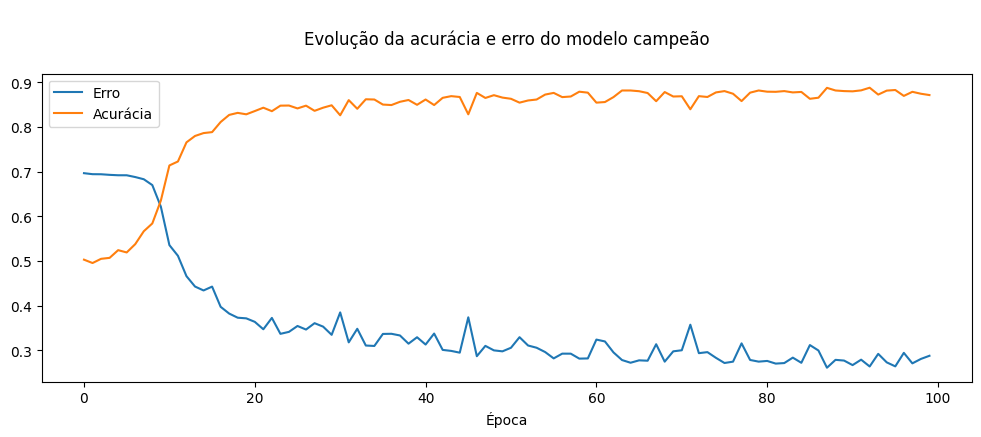

In [55]:
plt.figure(figsize=(12, 4))
plt.plot(lstm_petr4.c_model_statistics_train[champion_index_petr4][1])
plt.plot(lstm_petr4.c_model_statistics_train[champion_index_petr4][0])
plt.title("\nEvolução da acurácia e erro do modelo campeão\n")
plt.xlabel("Época")
plt.legend(["Erro", "Acurácia"], loc="upper left")
plt.show()

In [56]:
y_pred_petr4 = (lstm_petr4.c_predicts[champion_index_petr4] > 0.5).astype(int)
confu_matrix_petr4 = confusion_matrix(y_test_petr4, y_pred_petr4)
class_report_petr4 = classification_report(y_test_petr4, y_pred_petr4)

print(f"\nInformações do modelo campeão:\n\n -> Topologia: {champion_index_petr4}\n\n -> Acurácia: {current_accuracy_petr4}%\n\n -> Erro: {current_loss_petr4}%\n\n -> Matriz de confusão\n{confu_matrix_petr4}\n\n -> Reporte de classificação\n{class_report_petr4}")


Informações do modelo campeão:

 -> Topologia: 32

 -> Acurácia: 0.91%

 -> Erro: 0.23%

 -> Matriz de confusão
[[509  72]
 [286 336]]

 -> Reporte de classificação
              precision    recall  f1-score   support

           0       0.64      0.88      0.74       581
           1       0.82      0.54      0.65       622

    accuracy                           0.70      1203
   macro avg       0.73      0.71      0.70      1203
weighted avg       0.74      0.70      0.69      1203



Assim como nos casos anteriores, a 32° topologia (3x LSTM com 64 neurônios + 3x Dropout com rate de 0.3 + 1x Densa + Normalização: Não) apresentou a maior acurácia dentre as demais. 

Entretanto, diferentemente das predições realizadas para as ações da CSNA3 (Companhia Siderúrgica Nacional), as predições realizadas para a PETR4 (Petrobras) apresentaram mais (~20% CSNA3 vs ~29% PETR4) Falsos Positivos e Falsos Negativos, o que implica diretamente em uma maior perda de dinheiro, uma vez que estaríamos vendendo em um momento mais propício para compra.

Além disso, vale evidenciar que assim como no conjunto de dados de treinamento das ações CSNA3, também aplicamos a técnica de SMOTE para balancear a distribuição das classes no conjunto de dados de treinamento das ações PETR4.

___

#### Leitura e análise do conjunto de treino das ações da Vale (VALE3)

In [57]:
raw_vale3_train = pd.read_csv("_datasets/vale3/treino.csv")
raw_vale3_train.tail(5)

,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
4803,4804,2019-02-19,31.030128,31.429234,-1,30.866413,31.296162,31.146086,31.030128,30.218393,28.663134,29.440762,28.369816,28.963266,30.368454,30.477600,31.548546,31.036947,31.787289,29.154266
4804,4805,2019-02-20,31.241589,31.410470,-1,31.030128,30.866413,31.296162,31.146086,31.030128,30.218393,28.663134,29.440762,28.369816,28.963266,30.368454,30.477600,31.548546,31.036947,31.787289
4805,4806,2019-02-21,30.955091,31.364932,-1,31.241589,31.030128,30.866413,31.296162,31.146086,31.030128,30.218393,28.663134,29.440762,28.369816,28.963266,30.368454,30.477600,31.548546,31.036947
4806,4807,2019-02-22,32.053322,31.433771,-1,30.955091,31.241589,31.030128,30.866413,31.296162,31.146086,31.030128,30.218393,28.663134,29.440762,28.369816,28.963266,30.368454,30.477600,31.548546
4807,4808,2019-02-25,32.141998,31.504594,-1,32.053322,30.955091,31.241589,31.030128,30.866413,31.296162,31.146086,31.030128,30.218393,28.663134,29.440762,28.369816,28.963266,30.368454,30.477600


Perceba que, ao importar o conjunto de dados de treino, podemos realizar algumas alterações para facilitar a análise e manipulação das informações.

- Remoção de variáveis

    - "Unnamed: 0" : o registro representa um índice.
    - "Date" : o registro representa a data de coleta do dado.
    - "Smoothed_Close" : o registro representa o valor suavizado do fechamento do ativo - citado como "apenas uma curiosidade".

- Ordenação das variáveis

    - Para facilitar a interpretação, iremos ordenar o conjunto de dados de treino pelas variáveis independentes seguidas da variável dependente.

In [58]:
spec_vale3_train = raw_vale3_train.drop(columns="Smoothed_Close")
spec_vale3_train = spec_vale3_train[["Close", "Past_1_Days_Close", "Past_2_Days_Close", "Past_3_Days_Close", "Past_4_Days_Close", "Past_5_Days_Close", "Past_6_Days_Close", "Past_7_Days_Close", "Past_8_Days_Close", "Past_9_Days_Close", "Past_10_Days_Close", "Past_11_Days_Close", "Past_12_Days_Close", "Past_13_Days_Close", "Past_14_Days_Close", "Past_15_Days_Close", "Label"]]
spec_vale3_train.tail(5)

,Close,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close,Label
4803,31.030128,30.866413,31.296162,31.146086,31.030128,30.218393,28.663134,29.440762,28.369816,28.963266,30.368454,30.477600,31.548546,31.036947,31.787289,29.154266,-1
4804,31.241589,31.030128,30.866413,31.296162,31.146086,31.030128,30.218393,28.663134,29.440762,28.369816,28.963266,30.368454,30.477600,31.548546,31.036947,31.787289,-1
4805,30.955091,31.241589,31.030128,30.866413,31.296162,31.146086,31.030128,30.218393,28.663134,29.440762,28.369816,28.963266,30.368454,30.477600,31.548546,31.036947,-1
4806,32.053322,30.955091,31.241589,31.030128,30.866413,31.296162,31.146086,31.030128,30.218393,28.663134,29.440762,28.369816,28.963266,30.368454,30.477600,31.548546,-1
4807,32.141998,32.053322,30.955091,31.241589,31.030128,30.866413,31.296162,31.146086,31.030128,30.218393,28.663134,29.440762,28.369816,28.963266,30.368454,30.477600,-1


Com o conjunto de dados de treino ordenado e livre de variáveis que não serão utilizadas, podemos realizar a análise inicial dos dados.

In [59]:
spec_vale3_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4808 entries, 0 to 4807
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Close               4808 non-null   float64
 1   Past_1_Days_Close   4808 non-null   float64
 2   Past_2_Days_Close   4808 non-null   float64
 3   Past_3_Days_Close   4808 non-null   float64
 4   Past_4_Days_Close   4808 non-null   float64
 5   Past_5_Days_Close   4808 non-null   float64
 6   Past_6_Days_Close   4808 non-null   float64
 7   Past_7_Days_Close   4808 non-null   float64
 8   Past_8_Days_Close   4808 non-null   float64
 9   Past_9_Days_Close   4808 non-null   float64
 10  Past_10_Days_Close  4808 non-null   float64
 11  Past_11_Days_Close  4808 non-null   float64
 12  Past_12_Days_Close  4808 non-null   float64
 13  Past_13_Days_Close  4808 non-null   float64
 14  Past_14_Days_Close  4808 non-null   float64
 15  Past_15_Days_Close  4808 non-null   float64
 16  Label 

Assim como o conjunto de dados de treino com as ações da Petrobras (PETR4), não foram identificados nenhum atributo nulo nas colunas do conjunto de dados de treino com as ações da VALE3, dessa forma não será necessário realizar a remoção de registros ou imputar valores para completar o conjunto de dados.

Sendo assim, como próximos passos, iremos analisar o comportamento das variáveis a fim de entender se o conjunto de dados de treino está balanceado (número de compras e vendas similar) e, em seguida, verificar a correlação entre as variáveis.

In [60]:
label_distribution = ddb.sql("""SELECT Label, COUNT(*) AS Regs from spec_vale3_train GROUP BY 1""").to_df()
size = spec_vale3_train.shape[0]
buy_count = label_distribution["Regs"][0]
sell_count = label_distribution["Regs"][1]
buy_percentual = round((buy_count / size) * 100, 2)
sell_percentual = round((sell_count / size) * 100, 2)

print(f"O conjunto de dados possui {size} registros, onde:")
print(f" -> Vendas: {buy_count} ou {buy_percentual}%")
print(f" -> Compras: {sell_count} ou {sell_percentual}%")

O conjunto de dados possui 4808 registros, onde:
 -> Vendas: 2092 ou 43.51%
 -> Compras: 2716 ou 56.49%


O conjunto de dados de treino apresenta uma inclinação para classificar compras, sendo assim, iremos utilizar a técnica Smote para realizar o balanceamento entre as classes quando formos treinar o modelo, evitando que o modelo torne-se especialista em uma determinada classe.

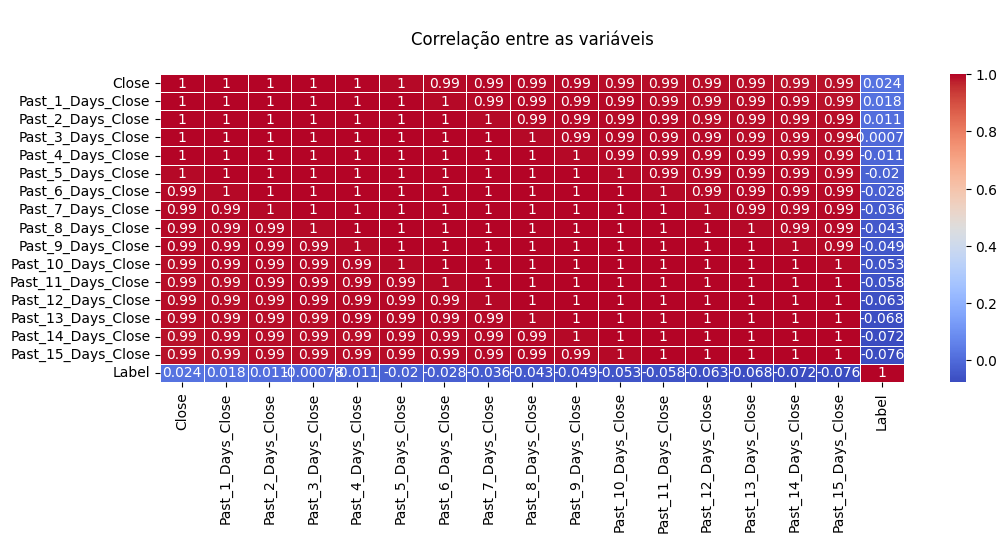

In [61]:
correlation = spec_vale3_train.select_dtypes("number").corr()

plt.figure(figsize=(12, 4))

sns.heatmap(
    correlation, 
    annot=True, 
    annot_kws={"size" : 10},
    cmap="coolwarm",
    cbar=True,
    linewidths=0.5,
    linecolor="white"
)

plt.title("\nCorrelação entre as variáveis\n", fontdict={"size" : 12})

plt.show()

Assim como apresentado no conjunto de dados de treino das ações PETR4 (Petrobras), o conjunto de dados de treino das ações VALE3 (Vale) apresentam as seguintes características:

- Variável dependente: a correlação entre a ação de venda/compra diminui ao passar dos dias, ou seja, considerando APENAS o que é apresentado acima, poderíamos pressupor que a ação é tomada com base nos dados mais recentes, ou seja, uma janela mais curta de dias.

- Variáveis independentes: diferente da variável dependente, todas as variáveis independentes apresentam uma alta correlação entre sí, o que nos leva a pensar que o valor de fechamento em D-15 influencia em D-14 e assim sucessivamente.

Posto isso, iremos desenvolver um modelo baseline para fazer uma classificação inicial das ações.

#### Leitura e análise do conjunto de teste das ações da Vale (VALE3)

In [62]:
raw_vale3_test = pd.read_csv("_datasets/vale3/teste.csv")
raw_vale3_test.tail(5)

,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
1198,6007,2023-12-21,76.970001,73.724733,1,74.489998,74.730003,74.209999,73.860001,73.400002,73.000000,72.989998,72.860001,72.800003,72.599998,72.370003,72.849998,73.529999,75.220001,73.849998
1199,6008,2023-12-22,76.389999,73.991260,1,76.970001,74.489998,74.730003,74.209999,73.860001,73.400002,73.000000,72.989998,72.860001,72.800003,72.599998,72.370003,72.849998,73.529999,75.220001
1200,6009,2023-12-26,76.660004,74.258134,1,76.389999,76.970001,74.489998,74.730003,74.209999,73.860001,73.400002,73.000000,72.989998,72.860001,72.800003,72.599998,72.370003,72.849998,73.529999
1201,6010,2023-12-27,77.400002,74.572321,1,76.660004,76.389999,76.970001,74.489998,74.730003,74.209999,73.860001,73.400002,73.000000,72.989998,72.860001,72.800003,72.599998,72.370003,72.849998
1202,6011,2023-12-28,77.199997,74.835089,1,77.400002,76.660004,76.389999,76.970001,74.489998,74.730003,74.209999,73.860001,73.400002,73.000000,72.989998,72.860001,72.800003,72.599998,72.370003


Para mantermos o padrão, iremos realizar os mesmos tratamentos que foram realizados no conjunto de treino no conjunto de teste, ou seja, a remoção das colunas "Unamed: 0", "Date" e "Smoothed_Close" (que não serão utilizadas no treinamento dos modelos) e a ordenação das variáveis para facilitar a leitura.

In [63]:
spec_vale3_test = raw_vale3_test.drop(columns="Smoothed_Close")
spec_vale3_test = spec_vale3_test[["Close", "Past_1_Days_Close", "Past_2_Days_Close", "Past_3_Days_Close", "Past_4_Days_Close", "Past_5_Days_Close", "Past_6_Days_Close", "Past_7_Days_Close", "Past_8_Days_Close", "Past_9_Days_Close", "Past_10_Days_Close", "Past_11_Days_Close", "Past_12_Days_Close", "Past_13_Days_Close", "Past_14_Days_Close", "Past_15_Days_Close", "Label"]]
spec_vale3_test.tail(5)

,Close,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close,Label
1198,76.970001,74.489998,74.730003,74.209999,73.860001,73.400002,73.000000,72.989998,72.860001,72.800003,72.599998,72.370003,72.849998,73.529999,75.220001,73.849998,1
1199,76.389999,76.970001,74.489998,74.730003,74.209999,73.860001,73.400002,73.000000,72.989998,72.860001,72.800003,72.599998,72.370003,72.849998,73.529999,75.220001,1
1200,76.660004,76.389999,76.970001,74.489998,74.730003,74.209999,73.860001,73.400002,73.000000,72.989998,72.860001,72.800003,72.599998,72.370003,72.849998,73.529999,1
1201,77.400002,76.660004,76.389999,76.970001,74.489998,74.730003,74.209999,73.860001,73.400002,73.000000,72.989998,72.860001,72.800003,72.599998,72.370003,72.849998,1
1202,77.199997,77.400002,76.660004,76.389999,76.970001,74.489998,74.730003,74.209999,73.860001,73.400002,73.000000,72.989998,72.860001,72.800003,72.599998,72.370003,1


Com o conjunto de dados de treino ordenado e livre de variáveis que não serão utilizadas, podemos realizar a análise inicial dos dados.

In [64]:
spec_vale3_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1203 entries, 0 to 1202
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Close               1203 non-null   float64
 1   Past_1_Days_Close   1203 non-null   float64
 2   Past_2_Days_Close   1203 non-null   float64
 3   Past_3_Days_Close   1203 non-null   float64
 4   Past_4_Days_Close   1203 non-null   float64
 5   Past_5_Days_Close   1203 non-null   float64
 6   Past_6_Days_Close   1203 non-null   float64
 7   Past_7_Days_Close   1203 non-null   float64
 8   Past_8_Days_Close   1203 non-null   float64
 9   Past_9_Days_Close   1203 non-null   float64
 10  Past_10_Days_Close  1203 non-null   float64
 11  Past_11_Days_Close  1203 non-null   float64
 12  Past_12_Days_Close  1203 non-null   float64
 13  Past_13_Days_Close  1203 non-null   float64
 14  Past_14_Days_Close  1203 non-null   float64
 15  Past_15_Days_Close  1203 non-null   float64
 16  Label 

Como apresentado acima, de fato não existem dados nulos, ou seja, assim como no conjunto de treino, não precisaremos realizar nenhum tipo de exclusão ou imputação de dados no conjunto de teste.

Sendo assim, podemos verificar se o conjunto de treino é balanceado, ou seja, se não existe uma diferença significativa entre o número de registros de venda e compra de ações.

In [65]:
label_distribution = ddb.sql("""SELECT Label, COUNT(*) AS Regs from spec_vale3_test GROUP BY 1""").to_df()
size = spec_vale3_test.shape[0]
buy_count = label_distribution["Regs"][0]
sell_count = label_distribution["Regs"][1]
buy_percentual = round(buy_count / size, 2)
sell_percentual = round(sell_count / size, 2)

print(f"O conjunto de dados possui {size} registros, onde:")
print(f" -> Vendas: {buy_count} ou {buy_percentual}%")
print(f" -> Compras: {sell_count} ou {sell_percentual}%")

O conjunto de dados possui 1203 registros, onde:
 -> Vendas: 601 ou 0.5%
 -> Compras: 602 ou 0.5%


Diferentemente do comportamento apresentado no conjunto de dados de teste das ações PETR4 (Petrobras), o conjunto de dados de teste das ações VALE3 (Vale) apresentam um balanceamento quase perfeito, entretanto, como a distribuição no conjunto de dados de treinamento foi alta, seguiremos com a aplicação da técnica SMOTE para realizar o treinamento.


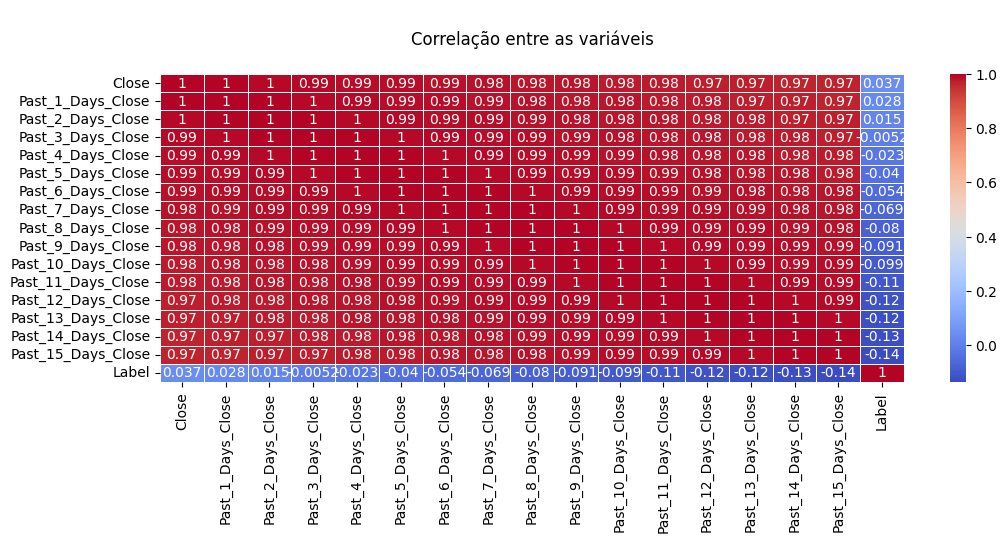

In [66]:
correlation = spec_vale3_test.select_dtypes("number").corr()

plt.figure(figsize=(12, 4))

sns.heatmap(
    correlation, 
    annot=True, 
    annot_kws={"size" : 10},
    cmap="coolwarm",
    cbar=True,
    linewidths=0.5,
    linecolor="white"
)

plt.title("\nCorrelação entre as variáveis\n", fontdict={"size" : 12})

plt.show()

Perceba que, após analisarmos a matriz de correlação do conjunto de dados de teste, observamos um comportamento semelhante a matriz de correlação do conjunto de dados de treino, ou seja, uma baixíssima correlação entre a variável dependente e as variáveis independentes.

#### Modelagem e avaliação dos resultados

In [67]:
print(f"Valores possíveis da variável alvo nos conjuntos de:\n -> Treino: {list(spec_vale3_train['Label'].unique())}\n -> Teste: {list(spec_vale3_test['Label'].unique())}")

Valores possíveis da variável alvo nos conjuntos de:
 -> Treino: [1, -1]
 -> Teste: [1, -1]


Como apresentado anteriormente, a variável alvo pode assumir os valores do intervalo [-1, 1], o que pode ser um problema ao utilizarmos a função de ativação sigmoid (que assume valores no intervalo [0, 1]), sendo assim, substituímos os valores -1 por 0.

In [68]:
spec_vale3_train["Label"] = spec_vale3_train["Label"].apply(lambda x: 0 if x == -1 else 1)
spec_vale3_test["Label"] = spec_vale3_test["Label"].apply(lambda x: 0 if x == -1 else 1)
print(f"Valores possíveis da variável alvo nos conjuntos de:\n -> Treino: {list(spec_vale3_train['Label'].unique())}\n -> Teste: {list(spec_vale3_test['Label'].unique())}")

Valores possíveis da variável alvo nos conjuntos de:
 -> Treino: [1, 0]
 -> Teste: [1, 0]


Feito isso, iremos realizar quatro testes para o baseline: sem normalizações, com standard scalling, com minmax scalling e com robust scalling. Para isso serão construídas as variáveis "x", "x_standard", "x_minmax" e "x_robust".

In [69]:
# Instancia o SMOTE para realizar o balanceamento das classes do conjunto de treino
smote = SMOTE(sampling_strategy="auto", random_state=42)

x_train_vale3 = np.array(spec_vale3_train.drop(columns=["Label"]))
x_test_vale3 = np.array(spec_vale3_test.drop(columns=["Label"]))

y_train_vale3 = np.array(spec_vale3_train["Label"])
y_test_vale3 = np.array(spec_vale3_test["Label"])

# Realiza o balanceamento de classes dos conjuntos do conjunto de treino
x_train_vale3, y_train_vale3 = smote.fit_resample(x_train_vale3, y_train_vale3)

x_standard_train_vale3 = np.array(StandardScaler().fit_transform(x_train_vale3))
x_standard_test_vale3 = np.array(StandardScaler().fit_transform(x_test_vale3))

x_minmax_train_vale3 = np.array(MinMaxScaler().fit_transform(x_train_vale3))
x_minmax_test_vale3 = np.array(MinMaxScaler().fit_transform(x_test_vale3))

x_robust_train_vale3 = np.array(RobustScaler().fit_transform(x_train_vale3))
x_robust_test_vale3 = np.array(RobustScaler().fit_transform(x_test_vale3))

x_list_train_vale3 = [["Não", x_train_vale3], ["Standard", x_standard_train_vale3], ["Minmax", x_minmax_train_vale3], ["Robust", x_robust_train_vale3]]
x_list_test_vale3 = [["Não", x_test_vale3], ["Standard", x_standard_test_vale3], ["Minmax", x_minmax_test_vale3], ["Robust", x_robust_test_vale3]]

Com as variáveis independentes tratadas, podemos iniciar o desenho da topologia da rede neural. 

Optamos por seguir com o uso das LSTM (Long Short-Term Memory), visto a sua capacidade de "lembrar" de dados já processados em um determinado espaço de tempo, o que as tornam fortes candidatas para solucionar o problema que queremos resolver: comprar ou vender uma determinada ação.

Sendo assim, iremos realizar testes utilizando as camadas LSTM, Dropout e Densa variando o número de camadas (1, 2 e 3) e neurônios (16, 32 e 64) para cada conjunto X (não normalizado, standard, minmax e robust) de variáveis.


In [70]:
grid_vale3 = [[1,16], [1,32], [1,64], [2,16], [2,32], [2,64], [3,16], [3,32], [3,64]]
grid_size_vale3 = len(grid_vale3)

In [71]:
# Inicializa variáveis auxiliares
network_index_vale3 = 0

# Instancia o modelo
lstm_vale3 = CL()

# Percorre o grid de treinos
for i in range(grid_size_vale3):
    # Percorre a lista de normalizações de treino
    for x_i_train_vale3, x_i_test_vale3 in zip(x_list_train_vale3, x_list_test_vale3):
        # Apresenta a topologia da i-ésima rede neural
        print(f"\nTopologia: {network_index_vale3}\n -> {grid_vale3[i][0]}x LSTM com {grid_vale3[i][1]} neurônios\n -> {grid_vale3[i][0]}x Dropout com rate de {round(0.1 * grid_vale3[i][0], 2)}\n -> 1x Densa\n -> Normalização: {x_i_train_vale3[0]}")
        # Constrói, compila e treina a topologia da i-ésima rede neural
        lstm_vale3.build_model(c_layers_number=grid_vale3[i][0], c_units_number=grid_vale3[i][1], c_dropout_rate=0.1, c_input_shape=(16, 1))
        lstm_vale3.compile_model(c_optimizer="adam", c_loss="binary_crossentropy", c_metrics=["accuracy"])
        lstm_vale3.fit_model(c_x=x_i_train_vale3[1], c_y=y_train_vale3, c_test_size=0.3, c_random_state=42, c_epochs_number=100, c_batches_number=64, c_verbose=0)
        lstm_vale3.evaluate_model()
        lstm_vale3.predict_model(c_x=x_i_test_vale3[1])
        network_index_vale3 += 1


Topologia: 0
 -> 1x LSTM com 16 neurônios
 -> 1x Dropout com rate de 0.1
 -> 1x Densa
 -> Normalização: Não
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8561 - loss: 0.3336
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Topologia: 1
 -> 1x LSTM com 16 neurônios
 -> 1x Dropout com rate de 0.1
 -> 1x Densa
 -> Normalização: Standard
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8351 - loss: 0.3840
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Topologia: 2
 -> 1x LSTM com 16 neurônios
 -> 1x Dropout com rate de 0.1
 -> 1x Densa
 -> Normalização: Minmax
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7756 - loss: 0.4264
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Topologia: 3
 -> 1x LSTM com 16 neurônios
 -> 1x Dropout com rate de 0.1
 -> 1x Densa
 -> Normalização: Robust
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8215 - loss: 0.3559
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Topologia: 4
 -> 1x LSTM com 32 neurônios
 -> 1x Dropout com rate de 0.1
 -> 1x Densa
 -> Normalização: 

In [72]:
# Inicializa variáveis auxiliares
champion_index_vale3 = 0
current_loss_vale3 = float("+inf")
current_accuracy_vale3 = float("-inf")

# Realiza a atualização para apresentar a arquitetura mais performática
for i_vale3 in range(len(lstm_vale3.c_model_scores_train)):
    if lstm_vale3.c_model_scores_train[i_vale3][0] < current_loss_vale3:
        current_loss_vale3 = round(lstm_vale3.c_model_scores_train[i_vale3][0], 2)
        champion_index_vale3 = i_vale3
    if lstm_vale3.c_model_scores_train[i_vale3][1] > current_accuracy_vale3:
        current_accuracy_vale3 = round(lstm_vale3.c_model_scores_train[i_vale3][1], 2)
        champion_index_vale3 = i_vale3

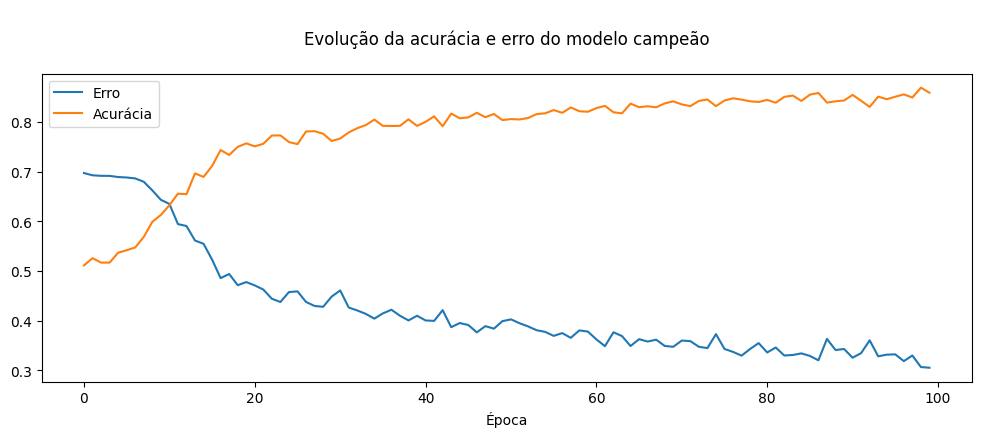

In [73]:
plt.figure(figsize=(12, 4))
plt.plot(lstm_vale3.c_model_statistics_train[champion_index_vale3][1])
plt.plot(lstm_vale3.c_model_statistics_train[champion_index_vale3][0])
plt.title("\nEvolução da acurácia e erro do modelo campeão\n")
plt.xlabel("Época")
plt.legend(["Erro", "Acurácia"], loc="upper left")
plt.show()

In [74]:
y_pred_vale3 = (lstm_vale3.c_predicts[champion_index_vale3] > 0.5).astype(int)
confu_matrix_vale3 = confusion_matrix(y_test_vale3, y_pred_vale3)
class_report_vale3 = classification_report(y_test_vale3, y_pred_vale3)

print(f"\nInformações do modelo campeão:\n\n -> Topologia: {champion_index_vale3}\n\n -> Acurácia: {current_accuracy_vale3}%\n\n -> Erro: {current_loss_vale3}%\n\n -> Matriz de confusão\n{confu_matrix_vale3}\n\n -> Reporte de classificação\n{class_report_vale3}")


Informações do modelo campeão:

 -> Topologia: 20

 -> Acurácia: 0.88%

 -> Erro: 0.28%

 -> Matriz de confusão
[[592   9]
 [473 129]]

 -> Reporte de classificação
              precision    recall  f1-score   support

           0       0.56      0.99      0.71       601
           1       0.93      0.21      0.35       602

    accuracy                           0.60      1203
   macro avg       0.75      0.60      0.53      1203
weighted avg       0.75      0.60      0.53      1203



Como apresentado acima, a 20° topologia (2x LSTM com 64 neurônios + 2x Dropout com rate de 0.2 + 1x Densa + Normalização: Não) apresentou a maior acurácia dentre as demais topologias. 

Entretanto, como citado nas predições realizadas para as ações BBAS3 (Banco do Brasil), utilizar apenas a acurácia como métrica de avaliação dos resultados pode ser um erro, uma vez que como apresentado acima as classificações apresentaram um alto número de Falsos Positivos e Falsos Negativos, o que acarretaria diretamente na venda de ações em um momento de compras.

Além disso, vale evidenciar que assim como no conjunto de dados de treinamento das ações CSNA4 e PETR4, também aplicamos a técnica de SMOTE para balancear a distribuição das classes no conjunto de dados de treinamento das ações VALE3.

___

#### Conclusões Finais

O problema de classificação do momento de compra ou venda de ações não é nada trivial, uma vez que o evento pode estar relacionado a fatores externos (ex. mudanças nos contextos político, econômico e social), sendo assim, basear-se apenas no histórico de fechamento das ações nos últimos 15 dias pode não ser a melhor abordagem para solução o problema.

Ainda assim, tivemos bons resultados e aprendizados com os experimentos, uma vez que conseguimos realizar diferentes treinamentos para cada empresa (BBAS3, CSNA3, PETR4 e VALE3) aplicando uma variedade de técnicas, como por exemplo, as normalizações e balanceamentos realizados nos conjuntos de treinamento.

Em um cenário fictício, onde o grupo tivesse que investir em uma das ações, optaríamos por seguir com a CSNA3, uma vez que a rede neural demonstrou ser mais precisa para definir se as ações deveriam ser compradas ou vendidas, apresentando ~20% de imprecisão nas escolhas.

___